In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from fancyimpute import IterativeImputer
import random

Using TensorFlow backend.


In [2]:
from catsim.cat import generate_item_bank
from catsim.simulation import *
from catsim.initialization import *
from catsim.selection import *
from catsim.estimation import *
from catsim.stopping import *
import catsim.plot as catplot
import seaborn as sns

In [3]:
course = pd.read_csv('./data/course.csv')
question = pd.read_csv('./data/question.csv', parse_dates=['created', 'modified'])
question_copy = pd.read_csv('./data/question.csv', parse_dates=['created', 'modified'])
topics = pd.read_csv('./data/topics.csv')
topics_copy = pd.read_csv('./data/topics.csv')
userquestion = pd.read_csv('./data/userquestion.csv', parse_dates=['created', 'modified'])
userquestionanswer = pd.read_csv('./data/userquestionanswer.csv', parse_dates=['created', 'modified'])
usersession = pd.read_csv('./data/usersession.csv', parse_dates=['created', 'modified', 'start_time', 'end_time'])
active_topics = pd.read_csv('./data/active_topics.csv')
eecs183_fr_fall18 = pd.read_csv('./data/eecs183_FR_fall18.csv')
gpao = pd.read_csv('./data/gpao.csv')

In [4]:
exam_dates = pd.read_csv('./data/exam_dates.csv', parse_dates=['exam_date'])
exam_scores = pd.read_csv('./data/eecs183_exam.csv').rename(columns={'fall18_exam1_mc':'fall18_exam1',
                                                                     'fall18_exam2_mc':'fall18_exam2'})

In [5]:
gpao = gpao.rename(columns={'SBJCT_CD||CATLG_NBR':'default_source'})

## Filters

In [6]:
# filter out user questions that weren't last year
start = pd.to_datetime('2018-09-04')
end = pd.to_datetime('2019-05-03')
userquestion = userquestion[(userquestion['created'] > start) & (userquestion['created'] < end)]

In [7]:
# filter out questions that were created but not answered most likely due to an exited session
userquestion = userquestion.dropna(subset=['correct'])

In [8]:
# filter out any non active topics from topics
active_topics = active_topics[active_topics['is_active'] == 1][['id', 'name']].rename(columns={'id':'topic_id'})
topics_copy = topics_copy[topics_copy['topic_id'].isin(active_topics['topic_id'].tolist())]
topics = topics[topics['topic_id'].isin(active_topics['topic_id'].tolist())]

## Joins

In [9]:
# make topic_id list in the same row as one question_id
grouped = topics.groupby('question_id')
question_num = []
topics_for_question = []
for name, group in grouped:
    question_num.append(name)
    topics_for_question.append(group['topic_id'].tolist())
edited_topics = pd.DataFrame(
    {'question_id' : question_num,
     'topic_id' : topics_for_question})

topics = edited_topics

In [10]:
# add topic to each question
question = pd.merge(question, topics, left_on='id', right_on='question_id', how='left', suffixes=('_left', '_right'))
question = question[['difficulty', 'course_id', 'question_id', 'topic_id']]

In [11]:
# add mode to each question for future sorting
userquestion = pd.merge(userquestion, usersession, left_on='user_session_id', right_on='id', how='left', suffixes=('_left', '_right'))
userquestion = userquestion[['id_left', 'question_id', 'user_session_id', 'correct', 'retry', 'skipped', 'start_time', 'end_time', 'course_id', 'user_id', 'modified_left', 'mode']]
userquestion = userquestion.rename(columns={'id_left':'id',
                                            'modified_left' : 'modified'})

In [12]:
# filter out anything that's not classic mode
userquestion = userquestion[userquestion['mode'] == 'classic']
userquestion = userquestion.drop(columns=['mode'])

In [13]:
# aggregating above merges into one to show question/session details on every answer given
userquestion = pd.merge(userquestion, question, left_on='question_id', right_on='question_id', how='left', suffixes=('_left', '_right'))
userquestion = userquestion[['id', 'question_id', 'user_session_id', 'correct', 'retry', 'skipped', 'start_time', 'end_time', 'user_id', 'modified', 'difficulty', 'course_id_left', 'topic_id']]
userquestion = userquestion.rename(columns={'course_id_left':'course_id'})

In [14]:
# rename merged data to df
df = userquestion

In [15]:
# filter out any answers to non active topics
df = df[df['question_id'].isin(topics_copy.question_id.unique())]

In [16]:
# join the free response and fix fall18 exams to add the fr to mc
fr_merged_exam_scores = pd.merge(exam_scores, eecs183_fr_fall18, how='left', on='ecoach_id').drop(columns=['pr_id_x']).rename(columns={'pr_id_y':'pr_id'})
fr_merged_exam_scores['fall18_exam1'] += fr_merged_exam_scores['fall18_exam1_fr']
fr_merged_exam_scores['fall18_exam2'] += fr_merged_exam_scores['fall18_exam2_fr']
exam_scores = fr_merged_exam_scores.drop(columns=['fall18_exam1_fr', 'fall18_exam2_fr'])

# Analysis

In [17]:
# add dummy for fall/winter semesters
mid = pd.to_datetime('2018-12-20')
df['fall_term'] = 0
df['winter_term'] = 0
df.loc[(df['modified'] > start) & (df['modified'] < mid), 'fall_term'] = 1
df.loc[(df['modified'] > mid) & (df['modified'] < end), 'winter_term'] = 1

/Users/sethsaps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sethsaps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/sethsaps/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

0.6878698473842277
0.3121301526157723


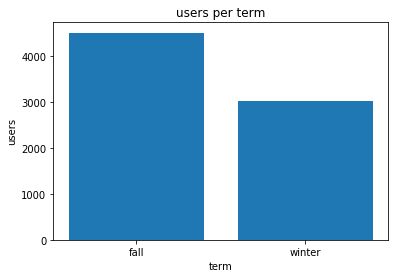

In [18]:
# see unique users per term
print(df['fall_term'].mean())
print(df['winter_term'].mean())
fall_unique = df[df['fall_term'] == 1][['user_id']].nunique()['user_id']
winter_unique = df[df['winter_term'] == 1][['user_id']].nunique()['user_id']
y = [fall_unique, winter_unique]
x_ticks = ('fall', 'winter')
x = np.arange(2)
plt.bar(x, y)
plt.title('users per term')
plt.xlabel('term')
plt.ylabel('users')
plt.xticks(x, x_ticks)
plt.show()

In [19]:
# sort by when user answered question
df = df.sort_values(by='modified')

In [20]:
# percent correct based on retried or not. More analysis later
print(df[(df['retry'] == 1) & (df['correct'] == 1)].count()['id'] / df[df['retry'] == 1].count()['id'])
print(df[(df['retry'] == 0) & (df['correct'] == 1)].count()['id'] / df[df['retry'] == 0].count()['id'])
# percent of total answers that are retried
print(df[df['retry'] == 1].count()['id'] / df.count()['id'])

0.5573397528572933
0.6377360562143171
0.35758546314931433


In [21]:
# get unique users per class per term, graph it
fall_unique = df[df['fall_term'] == 1].groupby(['course_id'])['user_id'].nunique()
winter_unique = df[df['winter_term'] == 1].groupby(['course_id'])['user_id'].nunique()

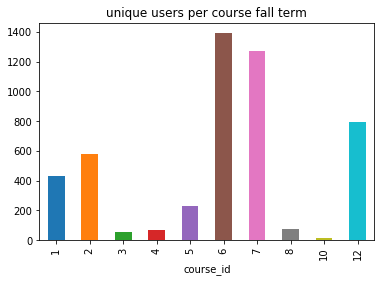

In [22]:
fall_unique.plot.bar(title='unique users per course fall term')

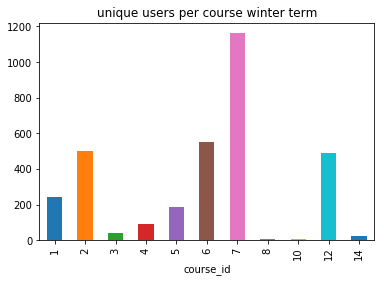

In [23]:
winter_unique.plot.bar(title='unique users per course winter term')

In [24]:
fall_average_questions = df[df['fall_term'] == 1].groupby(['course_id', 'user_id'])[['id']].nunique().groupby(['course_id'])[['id']].median()
winter_average_questions = df[df['winter_term'] == 1].groupby(['course_id', 'user_id'])[['id']].nunique().groupby(['course_id'])[['id']].median()

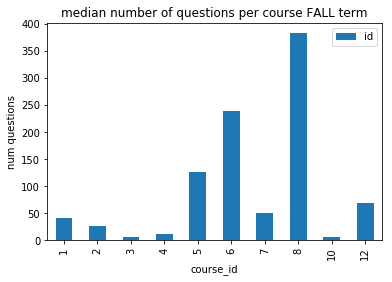

In [25]:
fall_average_questions.plot.bar(title='median number of questions per course FALL term')
plt.ylabel('num questions')
plt.show()

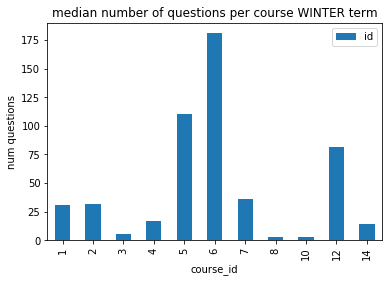

In [26]:
winter_average_questions.plot.bar(title='median number of questions per course WINTER term')
plt.ylabel('num questions')
plt.show()

In [27]:
fall_course_std = df[df['fall_term'] == 1].groupby(['course_id'])[['difficulty']].std()
winter_course_std = df[df['winter_term'] == 1].groupby(['course_id'])[['difficulty']].std()

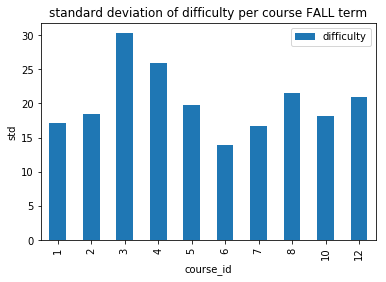

In [28]:
fall_course_std.plot.bar(title='standard deviation of difficulty per course FALL term')
plt.ylabel('std')
plt.show()

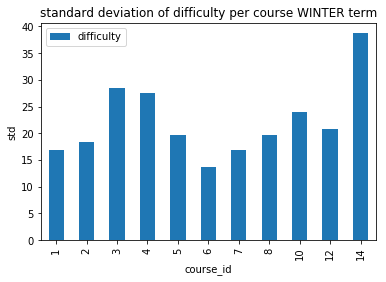

In [29]:
winter_course_std.plot.bar(title='standard deviation of difficulty per course WINTER term')
plt.ylabel('std')
plt.show()

In [30]:
topic_helper = pd.merge(question_copy, topics_copy, how='left', left_on='id', right_on='question_id', suffixes=('_left', '_right'))
topic_helper = topic_helper[['course_id', 'question_id', 'topic_id']]
topic_helper = topic_helper.dropna()

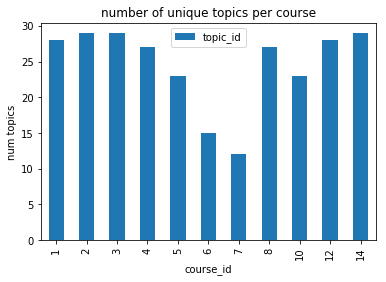

In [31]:
topic_helper.groupby(['course_id']).nunique()[['topic_id']].plot.bar(title='number of unique topics per course')
plt.ylabel('num topics')
plt.show()

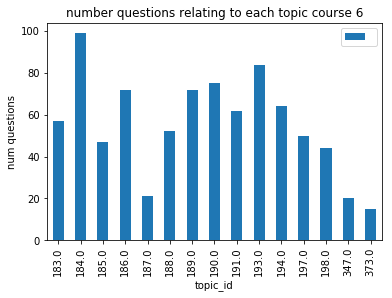

In [32]:
course_6 = topic_helper[topic_helper['course_id'] == 6]
course_6.groupby('topic_id').count().drop(columns=['course_id']).rename(columns=({'question_id' : ''})).plot.bar()
plt.ylabel('num questions')
plt.title('number questions relating to each topic course 6')
plt.show()

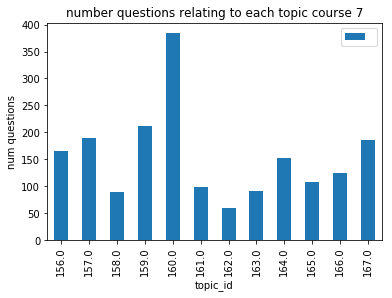

In [33]:
course_7 = topic_helper[topic_helper['course_id'] == 7]
course_7.groupby('topic_id').count().drop(columns=['course_id']).rename(columns=({'question_id' : ''})).plot.bar()
plt.ylabel('num questions')
plt.title('number questions relating to each topic course 7')
plt.show()

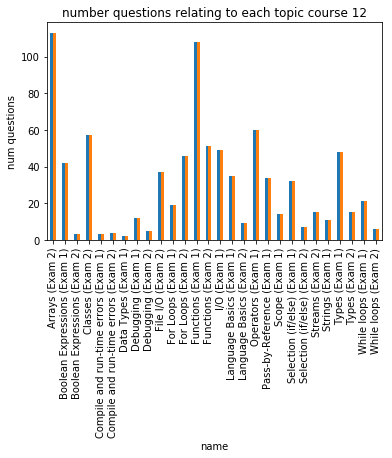

In [34]:
course_12 = topic_helper[topic_helper['course_id'] == 12]
course_12 = pd.merge(course_12, active_topics, how='left', on='topic_id')
course_12.groupby('name').count().drop(columns=['course_id']).rename(columns=({'question_id' : ''})).plot.bar(legend=None)
plt.ylabel('num questions')
plt.title('number questions relating to each topic course 12')
plt.show()

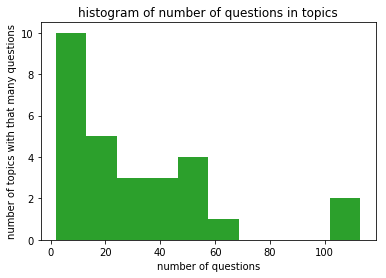

In [35]:
course_12.groupby('topic_id').count().plot.hist(legend=False)
plt.title('histogram of number of questions in topics')
plt.xlabel('number of questions')
plt.ylabel('number of topics with that many questions')
plt.show()

## Retry Exploration

In [36]:
# save original way retries are classified to see difference between the two ways
grouped_session = df.sort_values(by='modified').groupby(['user_id', 'question_id', 'user_session_id'])
grouped_ignore_session = df.sort_values(by='modified').groupby(['user_id', 'question_id'])

In [37]:
grouped_session_pcorrect = []
grouped_ignore_session_pcorrect = []
grouped_session_count = []
grouped_ignore_session_count = []
for n in range(10):
    grouped_session_pcorrect.append(grouped_session.nth(n)['correct'].mean())
    grouped_ignore_session_pcorrect.append(grouped_ignore_session.nth(n)['correct'].mean())
    grouped_session_count.append(grouped_session.nth(n)['correct'].count())
    grouped_ignore_session_count.append(grouped_ignore_session.nth(n)['correct'].count())

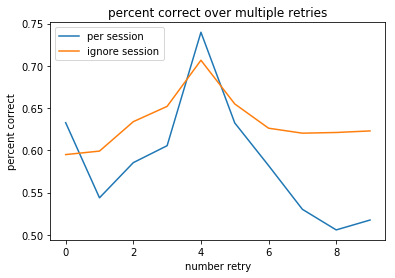

before it was averaging percent correct of people who retried x times, now looks at each retry individually


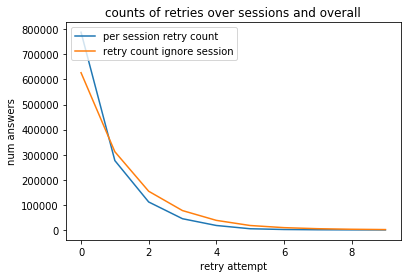

In [38]:
plt.plot(grouped_session_pcorrect, label='per session')
plt.plot(grouped_ignore_session_pcorrect, label='ignore session')
plt.legend(loc='upper left')
plt.title('percent correct over multiple retries')
plt.xlabel('number retry')
plt.ylabel('percent correct')
plt.show()
print('before it was averaging percent correct of people who retried x times, now looks at each retry individually')

plt.plot(grouped_session_count, label='per session retry count')
plt.plot(grouped_ignore_session_count, label='retry count ignore session')
plt.legend(loc='upper left')
plt.title('counts of retries over sessions and overall')
plt.xlabel('retry attempt')
plt.ylabel('num answers')
plt.show()

In [39]:
# retry in another session currently not marked as retry. Fixes that
not_retries_df = df.sort_values(by='modified').groupby(['user_id', 'question_id']).first()
not_retries_df['not_retries'] = 1
not_retries_df = not_retries_df[['id', 'not_retries']]
df = pd.merge(df, not_retries_df, how='left', on='id', suffixes=('_left', '_right'))
print(df['retry'].sum())
df['retry'] = 1
df.loc[df['not_retries'] == 1, 'retry'] = 0
print(df['retry'].sum())
print('number of questions retried in another session: ', str(623449 - 448414))
df = df.drop(columns=['not_retries'])

446139
620838
number of questions retried in another session:  175035


In [40]:
print('proportion correct that are not retries: ', float(df[df['retry'] != 1]['correct'].sum()) / df[df['retry'] != 1]['correct'].count())
print('proportion correct that are retries: ', float(df[df['retry'] == 1]['correct'].sum()) / df[df['retry'] == 1]['correct'].count())
print('num retries: ', df[df['retry'] == 1].count()['correct'])
print('num not retries: ', df[df['retry'] != 1].count()['correct'])

proportion correct that are not retries:  0.5949011255494133
proportion correct that are retries:  0.6232092752054481
num retries:  620838
num not retries:  626805


In [41]:
# 2 prop z test
p1 = float(df[df['retry'] != 1]['correct'].sum()) / df[df['retry'] != 1]['correct'].count()
p2 = float(df[df['retry'] == 1]['correct'].sum()) / df[df['retry'] == 1]['correct'].count()
n1 = df[df['retry'] == 1].count()['correct']
n2 = df[df['retry'] != 1].count()['correct']
p = ((p1*n1) + (p2*n2)) / (float(n1 + n2))
SE = math.sqrt(p*(1-p) * ((1.0/n1) + (1.0/n2)))
z = (p1 - p2) / SE
print('z: ', z)
print('Conclude the proportions are the same')

z:  -32.40030577961977
Conclude the proportions are the same


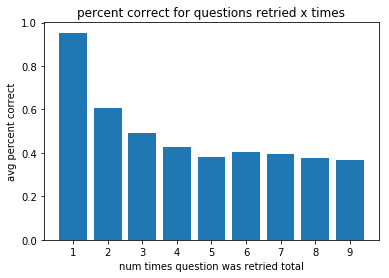

In [42]:
# indicate the number of times a question was retried
retry_count_df = df.groupby(['user_id', 'question_id']).count().rename(columns={'id':'num_times_retry'})[['num_times_retry']]
correct_retry_df = df.groupby(['user_id', 'question_id']).mean()[['correct']]
retry_percentage_df = pd.merge(retry_count_df, correct_retry_df, on=['user_id', 'question_id'])
retries = range(1, 10)
perc_cor_retries = []
for retry_num in retries:
    perc_cor = retry_percentage_df[retry_percentage_df['num_times_retry'] == retry_num]['correct'].mean()
    perc_cor_retries.append(perc_cor)
index = np.arange(len(retries))
plt.bar(index, perc_cor_retries)
plt.xlabel('num times question was retried total')
plt.ylabel('avg percent correct')
plt.title('percent correct for questions retried x times')
plt.xticks(index, retries)
plt.show()

Text(0,0.5,'frequency')

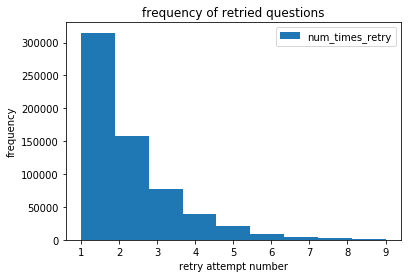

In [43]:
# indicate frequency of retried questions
retry_count_df[retry_count_df['num_times_retry'] < 10].plot.hist(bins=9)
plt.title('frequency of retried questions')
plt.xlabel('retry attempt number')
plt.ylabel('frequency')

# Item Response Theory

In [44]:
# filter out retry
df = df[df['retry'] == 0]

In [45]:
# returns a df with all responses left merged with their topic/topics
def get_topics(course_id):
    course_df = df[df['course_id'] == course_id]
    topic_count_df = pd.merge(course_df, topics_copy, how='left', on='question_id', suffixes=('_left', '_right'))
    topic_count_df = topic_count_df.rename(columns={'id_left':'id',
                                                    'topic_id_right':'topic_id'}).drop(columns=['topic_id_left', 'id_right'])
    # if printed out will show the most popular topics for a course
    topic_count_df.groupby('topic_id').count().sort_values(by='id', ascending=False)[['id']].head()
    return topic_count_df

In [46]:
# returns df of answers in a topic with users that have answered at least 30 percent of the questions in the topic
def get_users_plus20p(topic, topic_count_df):
    topic_only_df = topic_count_df[topic_count_df['topic_id'] == topic]
    simulation_user_freq = topic_only_df.groupby('user_id').count().sort_values(by='id', ascending=False)[['id']].rename(columns={'id' : 'frequency'})
    freq_users = simulation_user_freq[(simulation_user_freq['frequency'] / simulation_user_freq['frequency'].max()) >= 0.3].index.tolist()
    simulation_df_irt = topic_only_df[topic_only_df['user_id'].isin(freq_users)]
    return simulation_df_irt

In [47]:
# given a df of answers over multiple topics, returns a answer matrix for irt input
def answer_matrix(sim, topic):
    topic_qids = topics_copy[topics_copy['topic_id'] == topic]['question_id'].tolist()
    answers_df = pd.DataFrame(np.nan, index=sim.user_id.unique(), columns=list(map(str, topic_qids)))
    for user in sim.user_id.unique():
        user_df = sim[sim['user_id'] == user]
        user_correct = user_df['correct'].tolist()
        user_qid = user_df['question_id'].tolist()
        user_qid = list(map(str, user_qid))
        for i in range(len(user_correct)):
            answers_df.at[user, user_qid[i]] = user_correct[i]
    return answers_df      

In [48]:
# returns each topic and the number of questions in that topic for a course
def questions_in_topic(course_id):
    question_topic_course_df = pd.merge(topics_copy, question_copy[['id', 'course_id']], how='left', left_on='question_id', right_on='id', suffixes=('_left', '_right')).drop(columns=['id_left', 'id_right'])
    topics_question_count = question_topic_course_df[question_topic_course_df['course_id'] == course_id].groupby('topic_id').count()[['question_id']]
    return topics_question_count

In [49]:
# shows how many answers there are to each question in a topic
def answers_per_question_in_topic(topic):
    question_ids = topics_copy[topics_copy['topic_id'] == topic]['question_id'].tolist()
    num_answers = []
    for q in question_ids:
        num_answers.append(df[df['question_id'] == q].count()['id'])
    plt.bar(list(map(str, question_ids)), num_answers)
    plt.title('num answers for each question in topic ' + (str)(topic))
    plt.ylabel('num answers')
    plt.show()

In [50]:
# imputes missing cells to answer matrix and exports to csv for that topic
def impute_and_export(topic_answer_mat, topic):
    cols = list(topic_answer_mat)
    index = topic_answer_mat.index.values.tolist()

    # Impute missing values
    imputer = IterativeImputer(n_iter=50, random_state=0, min_value=0.0, max_value=1.0)
    topic_answer_mat_complete = imputer.fit_transform(topic_answer_mat)

    for i in range(len(topic_answer_mat_complete)):
        for j in range(len(topic_answer_mat_complete[i])):
            if random.uniform(0,1) <= topic_answer_mat_complete[i][j]:
                topic_answer_mat_complete[i][j] = 1
            else:
                topic_answer_mat_complete[i][j] = 0
    topic_answer_mat_complete = pd.DataFrame.from_records(topic_answer_mat_complete)
    topic_answer_mat_complete['user_id'] = index
    topic_answer_mat_complete = topic_answer_mat_complete.set_index('user_id')
    topic_answer_mat_complete.columns = cols

    topic_answer_mat_complete.to_csv('./imputed_answers/topic_' + (str)(topic) + '.csv')

In [51]:
# call when you need to export all topic answer matrices for a course id, verbose will show missingness per question in each topic
def export_answer_matrix_all_topics(course_id, verbose=False, impute=False):
    top_count_df = get_topics(course_id)
    for topic in top_count_df.topic_id.unique():
        topic_sim_df = get_users_plus20p(topic, top_count_df)
        answers = answer_matrix(topic_sim_df, topic).dropna(axis=1, how='all')
        if answers.shape[0] >= 20 and answers.shape[1] >= 20:
            if verbose:
                (answers.isnull().sum() / answers.shape[0]).plot.bar()
                plt.title('percent missing per question in topic ' + (str)(topic))
                plt.xlabel('question_id')
                plt.ylabel('percent missing')
                plt.show()
            if impute:
                impute_and_export(answers, topic)
            else:
                answers.index.name = 'user_id'
                answers.to_csv('./answers/topic_' + (str)(topic) + '.csv')
    #sim_df = get_users_plus50q(338, top_count_df)

In [52]:
# function call to export all topic answer matrices for a course id
export_answer_matrix_all_topics(12)

Text(0,0.5,'frequency')

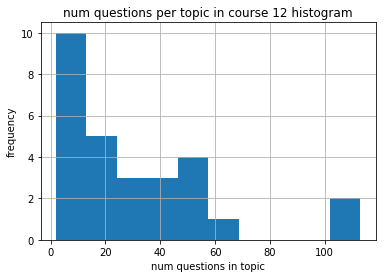

In [53]:
question_topic_course_df = pd.merge(topics_copy, question_copy[['id', 'course_id']], how='left', left_on='question_id', right_on='id', suffixes=('_left', '_right')).drop(columns=['id_left', 'id_right'])
question_topic_course_df[question_topic_course_df['course_id'] == 12].groupby('topic_id').count()['question_id'].hist()
plt.title('num questions per topic in course 12 histogram')
plt.xlabel('num questions in topic')
plt.ylabel('frequency')

In [54]:
print('number of topics in course 12: ', question_topic_course_df[question_topic_course_df['course_id'] == 12].topic_id.nunique())
print('number of topics able to use for IRT: 14')

number of topics in course 12:  28
number of topics able to use for IRT: 14


# Computer Adaptive Testing (CAT) Simulator

In [55]:
class TopicSimulation:
    def __init__(self, topic_id_, df):
        top_count_df = self.get_popular_topics(12, df)
        self.sim_df = self.get_users(topic_id_, top_count_df, percent=0.3)
        
        self.param_df = pd.read_csv("./parameters/topic_" + (str)(topic_id_) + ".csv").rename(columns={'Unnamed: 0':'question_id'})
        self.param_df['Gussng'] = 0.25
        self.param_df['question_id'] = list(map(int, self.param_df['question_id'].str[1:]))
        
        # fix extreme outliers that will ruin normalization
        self.param_df.loc[self.param_df['Dscrmn'] > 5, 'Dscrmn'] = self.param_df[self.param_df['Dscrmn'] <= 5]['Dscrmn'].max()
        self.param_df.loc[self.param_df['Dffclt'] > 30, 'Dffclt'] = self.param_df[self.param_df['Dffclt'] <= 30]['Dffclt'].max()
        self.param_df.loc[self.param_df['Dscrmn'] < -5, 'Dscrmn'] = self.param_df[self.param_df['Dscrmn'] >= -5]['Dscrmn'].min()
        self.param_df.loc[self.param_df['Dffclt'] < -30, 'Dffclt'] = self.param_df[self.param_df['Dffclt'] >= -30]['Dffclt'].min()
        
        self.param_df['upper_bound'] = 1
        
        self.sim_df = pd.merge(self.sim_df, self.param_df, how='left', on='question_id', suffixes=('_left', '_right'))
        
        self.topic_id = topic_id_
        
        self.prediction_df = pd.DataFrame(columns=['question_id', 'topic_id', 'user_id', 'current_ability', 'max_ability', 'num_questions', 'correct'])
        
    def get_popular_topics(self, course_id, df):
        course_df = df[df['course_id'] == course_id]
        topic_count_df = pd.merge(course_df, topics_copy, how='left', on='question_id', suffixes=('_left', '_right'))
        # if printed out will show the most popular topics for a course
        topic_count_df.groupby('topic_id_right').count().sort_values(by='id_left', ascending=False)[['id_left']].head()
        return topic_count_df
    
    def get_users(self, topic, topic_count_df, percent=0.0):
        simulation_df = topic_count_df[topic_count_df['topic_id_right'] == topic].drop(columns=['topic_id_left', 'id_right'])
        simulation_df = simulation_df.rename(columns={'id_left':'id',
                                                      'topic_id_right':'topic_id'})
        simulation_user_freq = simulation_df.groupby('user_id').count().sort_values(by='id', ascending=False)[['id']].rename(columns={'id' : 'frequency'})
        freq_users = simulation_user_freq[(simulation_user_freq['frequency'] / simulation_user_freq['frequency'].max()) >= percent].index.tolist()
        simulation_df_irt = simulation_df[simulation_df['user_id'].isin(freq_users)]
        return simulation_df_irt
    
    def get_user_id_list(self):
        return self.sim_df.user_id.unique()
    
    def simulate_user(self, user_id=-1, show=False, window_size=-1, increment=False):
        # checks user in param or assigns random
        if user_id not in self.sim_df.user_id.unique():
            users = self.sim_df.user_id.unique()
            user_id = random.choice(users)
        
        # get info on user sorted by time
        user_df = self.sim_df[self.sim_df['user_id'] == user_id]
        user_df = user_df.sort_values(by='modified')
        
        # get IRT info on users questions and get question_id's
        abc_mat = np.array(user_df[['Dscrmn', 'Dffclt', 'Gussng', 'upper_bound']])
        qids = user_df['question_id'].tolist()
        
        bank_size = len(qids)
        items = abc_mat
        
        # get true false answers from user
        responses = list(map(bool, user_df['correct'].tolist()))
        administered_items = range(len(responses))
        
        # init list of estimations from CAT sim
        estimations = []

        # first and last items used for each ability estimation
        begin = 0
        end = 1

        estimator = HillClimbingEstimator()
        
        # loop over each question and create new estimation based on all/some questions that came before
        while end <= len(responses):
            
            # sets the moving window
            if window_size > 0:
                if end > window_size:
                    begin = end - window_size
                    
            # sets estimation init to 0 or the last estimated value
            if not estimations:
                initializer = FixedPointInitializer(0)
            else:
                initializer = FixedPointInitializer(estimations[-1])
                
            # set selectors, number of items, items and estimate theta
            selector = LinearSelector(range(begin, end))
            stopper = MaxItemStopper(end - begin)
            administered_items = range(begin, end)
            est_theta = initializer.initialize()
            new_theta = estimator.estimate(items=items, administered_items=administered_items, response_vector=responses[begin:end], est_theta=est_theta)
            estimations.append(new_theta)
            
            end += 1
        
        # add a little to each ability based on how many total answered correct
        num_correct = 0
        counter = 0
        percent_correct = []
        all_num_correct = []
        for cor in responses:
            if not increment:
                num_correct += 0
            else:
                num_correct += cor
            counter += 1
            all_num_correct.append(num_correct)
            percent_correct.append(float(num_correct) / counter)
        all_num_correct = np.array(all_num_correct) * 0.02

        # calculate max ability so far
        max_so_far = []
        for i in range(len(estimations)):
            if i < 10:
                max_so_far.append(0)
            else:
                max_so_far.append(max(np.array(estimations[10:i+1]) + all_num_correct[10:i+1]))

        # append results to prediction dataframe
        user_prediction_df = pd.DataFrame({
            'question_id': qids,
            'topic_id': [self.topic_id] * len(qids),
            'user_id': [user_id] * len(qids),
            'current_ability': estimations,
            'max_ability': max_so_far,
            'num_questions': range(len(qids)),
            'correct': responses,
            'Dffclt' : user_df['Dffclt'].tolist()})
        # filter out the first 10 questions due to non reliable ability
        user_prediction_df = user_prediction_df[user_prediction_df['num_questions'] >= 10]
        # append users df to all users in the topic
        self.prediction_df = self.prediction_df.append(user_prediction_df)
        
        if show:
            # plot max ability so far
            plt.plot(range(len(estimations)), max_so_far, label='max ability so far')

            # plot ability
            plt.plot(range(len(estimations)), (np.array(estimations) + all_num_correct), 'b', label='ability')
            plt.title('Ability for user ' + (str)(user_id) + ' in topic ' + (str)(self.topic_id))
            plt.xlabel('num question')
            plt.ylabel('estimated ability')

            # plot percent correct
            plt.plot(range(len(estimations)), percent_correct, '-g', label='percent correct')

            # plot correct or not
            plt.plot(range(len(responses)), responses, 'r', label='correct or not')

            plt.legend()
            plt.show()
            
        
        return (range(len(estimations)), estimations)
    
    def get_prediction_df(self):
        return self.prediction_df
    
    def simulate_all_users(self, connect=False, regress=False, scatter=False):
        users = self.sim_df.user_id.unique()
        all_x = []
        all_y = []
        for user in users:
            questions_nums, abilities = self.simulate_user(user_id=user, window_size=15, increment=True)
            all_x.extend(questions_nums)
            all_y.extend(abilities)
            if scatter:
                plt.scatter(questions_nums, abilities)
                if connect:
                    plt.plot(questions_nums, abilities)
        plt.title('scatter of all abilities of different people over time for topic ' + (str)(self.topic_id))
        plt.xlabel('num questions answered so far')
        plt.ylabel('ability')
        if scatter:   
            plt.axis([-5, 200, -5, 5])
            plt.show()
        if regress:
            sns.regplot(all_x, all_y, x_bins=50)
            plt.show()
            

In [56]:
def scatter_all_users_max_for_topic(topic_id, show=False):
    sim_topic = TopicSimulation(topic_id, df)
    all_users = sim_topic.get_user_id_list()
    user_hit_1 = []
    maxs = []
    total_q = []
    for user in all_users:
        num_q, est = sim_topic.simulate_user(user_id=user, show=show, window_size=15, increment=True)
        for i in range(10, len(num_q)):
            if est[i] >= 1.0:
                user_hit_1.append(num_q[i])
                break
        maxs.append(max(est[10:]))
        total_q.append(len(num_q))


    plt.scatter(total_q, maxs)
    plt.title('scatter of all users max ability vs questions answered to get there')
    plt.xlabel('question number')
    plt.ylabel('max ability for user')
    plt.show()

# Predictions

In [57]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn import tree
from sklearn.svm import SVC

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

In [58]:
topic_simulation_dict = {}

/Users/sethsaps/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


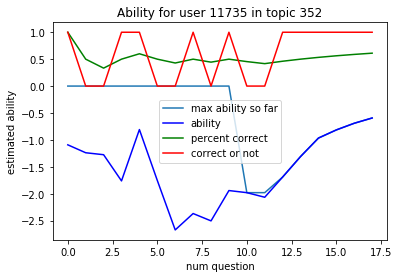

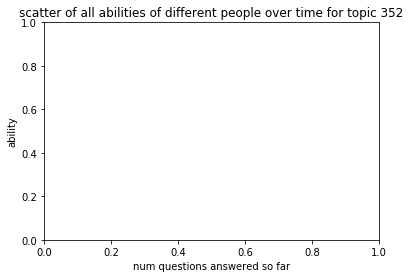

In [59]:
sim_topic = TopicSimulation(352, df)
sim_topic.simulate_user(show=True, increment=True)
if 352 in topic_simulation_dict:
    prediction_df = topic_simulation_dict[352]
else:
    sim_topic.simulate_all_users()
    prediction_df = sim_topic.get_prediction_df()
    topic_simulation_dict[352] = prediction_df

In [60]:
# uncomment to get regression plots of ability in each topic
'''
topics_12 = [336, 338, 339, 342, 344, 346, 348, 350, 352, 354, 355, 356, 362, 363]
for topic in topics_12:
    pd.read_csv('./parameters/topic_' + (str)(topic) + '.csv').hist()
    plt.show()
    TopicSimulation(topic, df)
    sim_topic.simulate_all_users(regress=True)
'''

"\ntopics_12 = [336, 338, 339, 342, 344, 346, 348, 350, 352, 354, 355, 356, 362, 363]\nfor topic in topics_12:\n    pd.read_csv('./parameters/topic_' + (str)(topic) + '.csv').hist()\n    plt.show()\n    TopicSimulation(topic, df)\n    sim_topic.simulate_all_users(regress=True)\n"

In [61]:
# get percent correct column
question_id_correct = prediction_df.groupby('question_id')[['correct']].sum() / prediction_df.groupby('question_id')[['correct']].count()
question_id_correct = question_id_correct.rename(columns={'correct': 'percent_correct'})
question_id_correct.reset_index(level=0, inplace=True)
prediction_df['question_id'] = prediction_df['question_id'].astype('int64')
prediction_df = pd.merge(prediction_df, question_id_correct, how='left', on='question_id', suffixes=('_left', '_right'))

Text(0,0.5,'frequency')

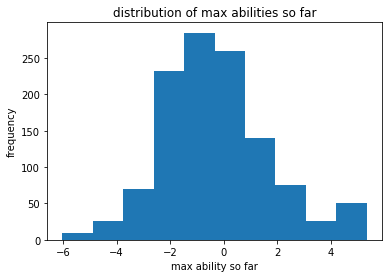

In [62]:
prediction_df['max_ability'].plot.hist()
plt.title('distribution of max abilities so far')
plt.xlabel('max ability so far')
plt.ylabel('frequency')

In [63]:
prediction_df.head()

,Dffclt,correct,current_ability,max_ability,num_questions,question_id,topic_id,user_id,percent_correct
0,4.425476,False,-2.080197,-1.980197,10,13266,352,11735,0.066667
1,2.913275,False,-2.165522,-1.980197,11,12805,352,11735,0.242424
2,-2.741782,True,-1.810221,-1.690221,12,13249,352,11735,0.815789
3,-1.457101,True,-1.449468,-1.309468,13,12862,352,11735,0.707317
4,-0.952104,True,-1.126118,-0.966118,14,13008,352,11735,0.689655


ability threshold:  1
mastery percent correct:  0.7536764705882353
mastery size:  272
non mastery percent correct;  0.5953436807095344
non mastery size:  902
ability threshold:  -0.5
mastery percent correct:  0.7924107142857143
mastery size:  448
non mastery percent correct;  0.5330578512396694
non mastery size:  726


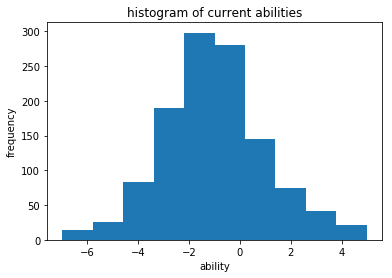

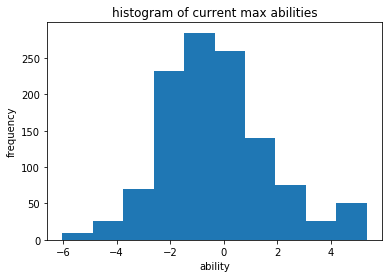

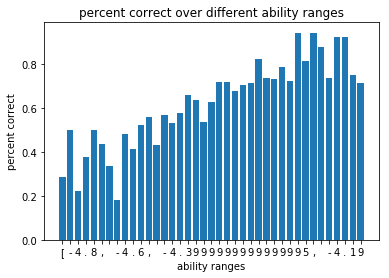

In [64]:
threshold = 1
print('ability threshold: ', threshold)
print('mastery percent correct: ', prediction_df[prediction_df['max_ability'] >= threshold]['correct'].mean())
print('mastery size: ', prediction_df[prediction_df['max_ability'] >= threshold].count()['question_id'])
print('non mastery percent correct; ', prediction_df[prediction_df['max_ability'] < threshold]['correct'].mean())
print('non mastery size: ', prediction_df[prediction_df['max_ability'] < threshold].count()['question_id'])

threshold = -0.5
print('ability threshold: ', threshold)
print('mastery percent correct: ', prediction_df[prediction_df['current_ability'] >= threshold]['correct'].mean())
print('mastery size: ', prediction_df[prediction_df['current_ability'] >= threshold].count()['question_id'])
print('non mastery percent correct; ', prediction_df[prediction_df['current_ability'] < threshold]['correct'].mean())
print('non mastery size: ', prediction_df[prediction_df['current_ability'] < threshold].count()['question_id'])



prediction_df['current_ability'].plot.hist()
plt.title('histogram of current abilities')
plt.xlabel('ability')
plt.ylabel('frequency')
plt.show()

prediction_df['max_ability'].plot.hist()
plt.title('histogram of current max abilities')
plt.xlabel('ability')
plt.ylabel('frequency')
plt.show()


percents_correct = []
diffs = []
ranges = list(np.arange(-5.0, 3, 0.2))

for i in range(1, len(ranges)):
    perc_cor = prediction_df[(prediction_df['current_ability'] > ranges[i-1]) & (prediction_df['current_ability'] <= ranges[i])]['correct'].mean()
    diff = prediction_df[(prediction_df['current_ability'] > ranges[i-1]) & (prediction_df['current_ability'] <= ranges[i])]['Dffclt'].mean()
    percents_correct.append(perc_cor)
    diffs.append(diff)
    
index = np.arange(len(percents_correct))
plt.bar(index, percents_correct)
plt.ylabel('percent correct')
plt.xlabel('ability ranges')
plt.title('percent correct over different ability ranges')
plt.xticks(index, str(ranges[1:]))
plt.show()

In [65]:
# normalize data
prediction_df['current_ability'] = (prediction_df['current_ability'] - prediction_df['current_ability'].min()) / (prediction_df['current_ability'].max() - prediction_df['current_ability'].min())
prediction_df['max_ability'] = (prediction_df['max_ability'] - prediction_df['max_ability'].min()) / (prediction_df['max_ability'].max() - prediction_df['max_ability'].min())
prediction_df['num_questions'] = (prediction_df['num_questions'] - prediction_df['num_questions'].min()) / (prediction_df['num_questions'].max() - prediction_df['num_questions'].min())
prediction_df['Dffclt'] = (prediction_df['Dffclt'] - prediction_df['Dffclt'].min()) / (prediction_df['Dffclt'].max() - prediction_df['Dffclt'].min())

In [66]:
def predict_on_questions_in_topic(prediction_df, show_tree=False, show_question=False, show_roc_curve=False):
    question_groups = prediction_df.groupby(['topic_id', 'question_id'])

    actual_performances = []
    pred_performances = []
    pred_performances_svm = []

    for name, group in question_groups:
        # to show the true false over abilites per question
        if show_question:
            incorrect_ability = group[group['correct'] == False]['current_ability'].tolist()
            correct_ability = group[group['correct'] == True]['current_ability'].tolist()
            plt.scatter(incorrect_ability, [0] * len(incorrect_ability))
            plt.scatter(correct_ability, [0] * len(correct_ability))
            plt.title('correct and incorrect over ability for question ' + str(name[1]) + ' in topic ' + str(name[0]))
            plt.xlabel('normalized ability')
            plt.show()
        

        # makes sure there's at least 4 false for k-fold cv
        if (group[group['correct'] == False]['correct'].count() >= 4 and
            group.count()['correct'] >= 8):
            # print('question_id: ', name[1])

            accuracy = []
            accuracy_svm = []

            # k fold cv
            skf = StratifiedKFold(n_splits=2)
            X, y = group[['current_ability']].values, np.array(group['correct'].tolist())
            X2 = group[['current_ability']].values

            for train_index, test_index in skf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                X2_train, X2_test = X2[train_index], X2[test_index]
                y_train, y_test = y[train_index], y[test_index]

                # decision tree that only classifies on ability
                clf = tree.DecisionTreeClassifier(max_depth=1)
                clf = clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                accuracy.append(accuracy_score(y_test, y_pred))

                # graph tree model
                if show_tree:
                    graph = Source(tree.export_graphviz(clf, out_file=None
                       , class_names=['0', '1'] 
                       , filled = True))
                    display(SVG(graph.pipe(format='svg')))

                '''
                # SVM that takes in all factors
                clf = SVC(gamma='auto')
                clf.fit(X2_train, y_train)
                y_pred2 = clf.predict(X2_test)
                accuracy_svm.append(accuracy_score(y_test, y_pred2))
                '''

            # scores based on predicting all right or all right, depending on which is better
            actual_perf = max([group['correct'].mean(), 1.0-group['correct'].mean()])
            actual_performances.append(actual_perf)

            # scores based on ML model mean accuracy from k fold cv
            pred_performances.append(np.array(accuracy).mean())
            pred_performances_svm.append(np.array(accuracy_svm).mean())

            if show_roc_curve:
                y = label_binarize(y, classes=[0, 1])
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)
                clf = tree.DecisionTreeClassifier(max_depth=1)
                
                probs = clf.fit(X_train, y_train).predict_proba(X_test)
                preds = probs[:,1]
                fpr, tpr, threshold = roc_curve(y_test, preds)
                roc_auc = auc(fpr, tpr)
                
                print(probs)
                
                plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
                plt.legend(loc='lower right')
                plt.plot([0, 1], [0, 1], 'r--')
                plt.xlim([0, 1])
                plt.ylim([0, 1])
                plt.ylabel('True Positive Rate')
                plt.xlabel('False Positive Rate')
                plt.title('ROC curve for depth 1 DT classifier for topic ' + str(name[0]) + ' question ' + str(name[1]))
                plt.show()
                
    plt.scatter(actual_performances, pred_performances)
    plt.title('predict by percent correct vs ability for topic ' + str(prediction_df.topic_id.unique()[0]))
    plt.xlabel('percent correct method')
    plt.ylabel('ability method')

    plt.plot([0.4, 1], [0.4, 1])

    plt.show()

    plt.scatter(actual_performances, pred_performances_svm, color='red')
    plt.title('predict by percent correct vs svm for topic ' + str(prediction_df.topic_id.unique()[0]))
    plt.xlabel('percent correct method')
    plt.ylabel('ability method')

    plt.plot([0.4, 1], [0.4, 1])

    plt.show()

/Users/sethsaps/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


num answers trained on:  1243


/Users/sethsaps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: Mean of empty slice.
/Users/sethsaps/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sethsaps/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)


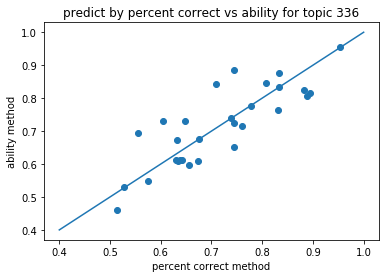

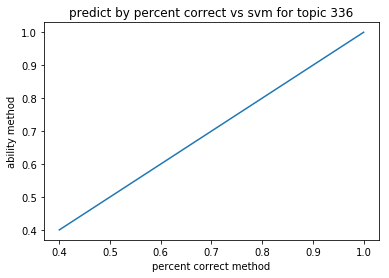

num answers trained on:  8535


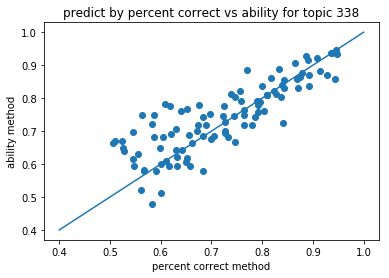

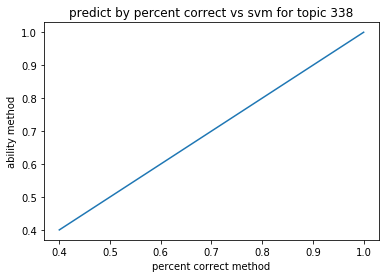

num answers trained on:  2174


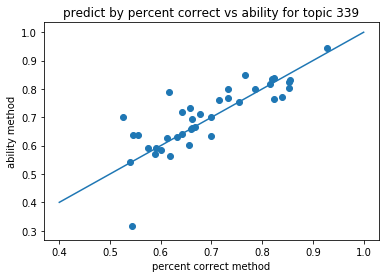

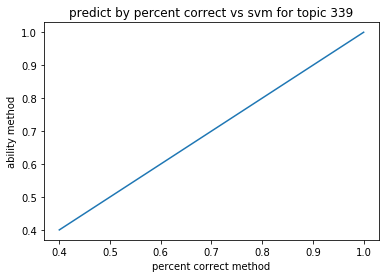

num answers trained on:  1637


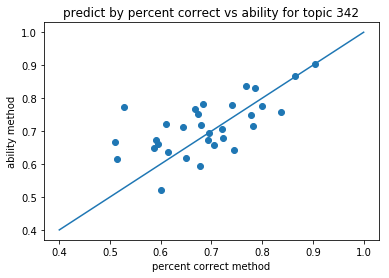

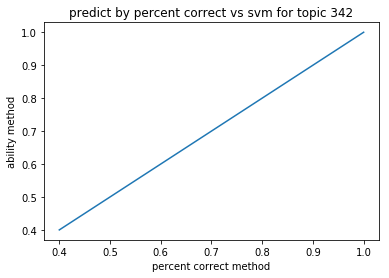

num answers trained on:  1418


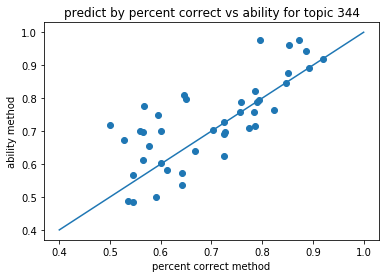

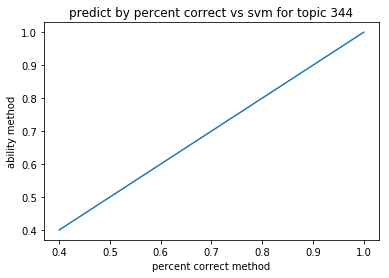

num answers trained on:  3923


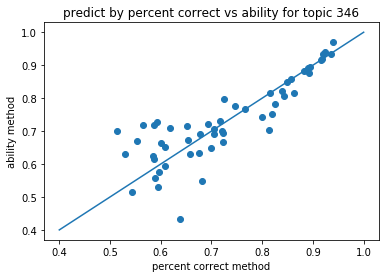

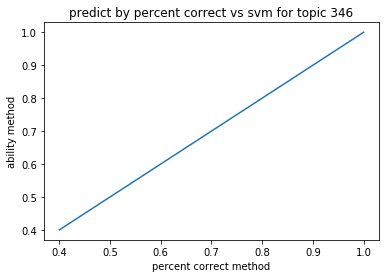

num answers trained on:  1832


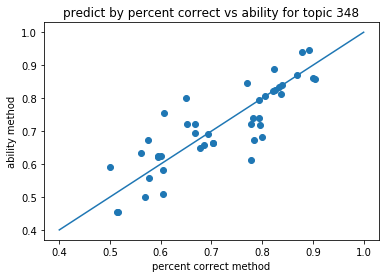

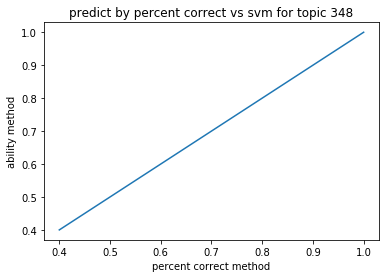

num answers trained on:  5537


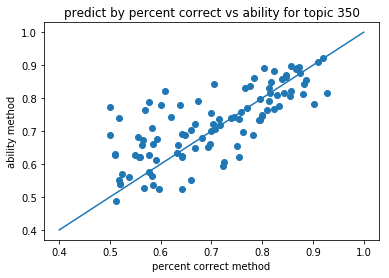

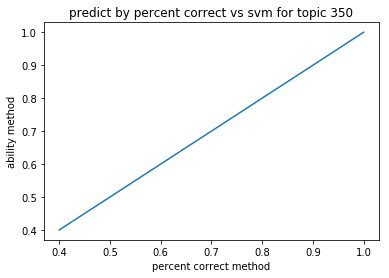

num answers trained on:  1174


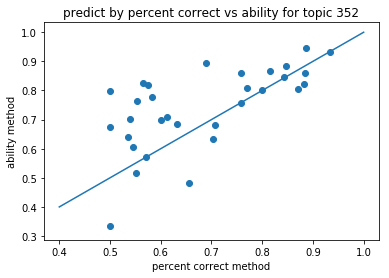

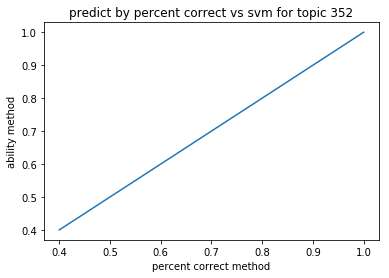

num answers trained on:  3295


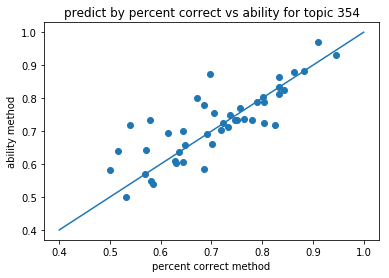

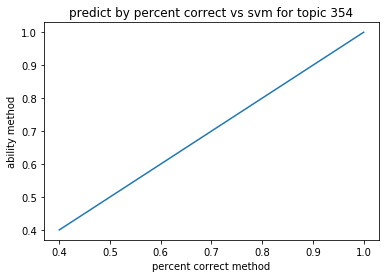

num answers trained on:  2081


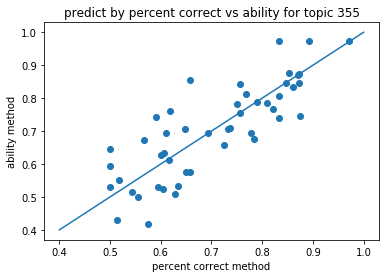

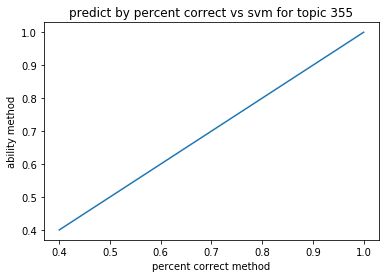

num answers trained on:  1842


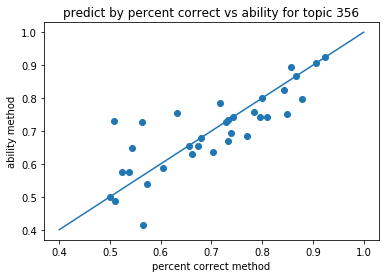

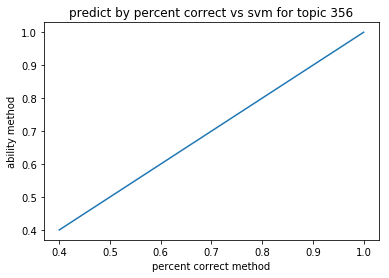

num answers trained on:  3039


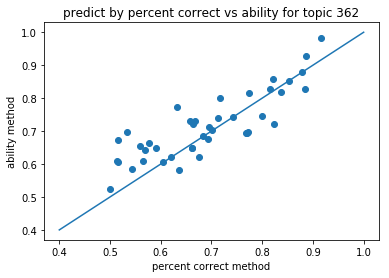

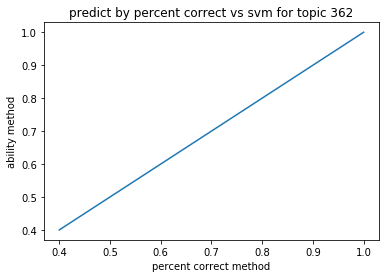

num answers trained on:  202


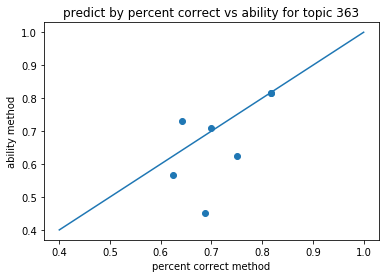

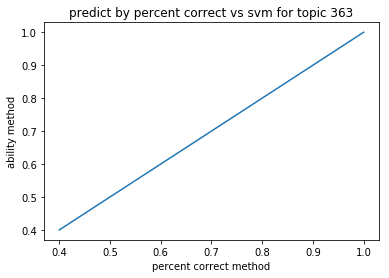

In [67]:
topics_12 = [336, 338, 339, 342, 344, 346, 348, 350, 352, 354, 355, 356, 362, 363]
for topic in topics_12:
    if topic in topic_simulation_dict:
        prediction_df = topic_simulation_dict[topic]
    else:
        sim_topic = TopicSimulation(topic, df)
        sim_topic.simulate_all_users()
        prediction_df = sim_topic.get_prediction_df()
        topic_simulation_dict[topic] = prediction_df
    print('num answers trained on: ', prediction_df.shape[0])
    predict_on_questions_in_topic(prediction_df)

# Exam Grades and PR Exploratory Analysis

In [68]:
# winter 19 exams are out of 200, need to standardize
exam_scores['win19_exam1'] = exam_scores['win19_exam1'] / 2
exam_scores['win19_exam2'] = exam_scores['win19_exam2'] / 2
exam_scores['fall18_exam1'] = exam_scores['fall18_exam1'] / 2
exam_scores['fall18_exam2'] = exam_scores['fall18_exam2'] / 2

In [69]:
# get rid of anything where all null for 4 exams. prob didn't take the class that sem or dropped too early
exam_scores = exam_scores[(exam_scores['fall18_exam1'].notnull()) | (exam_scores['fall18_exam2'].notnull())
            | (exam_scores['win19_exam1'].notnull()) | (exam_scores['win19_exam2'].notnull())]


Text(0,0.5,'count')

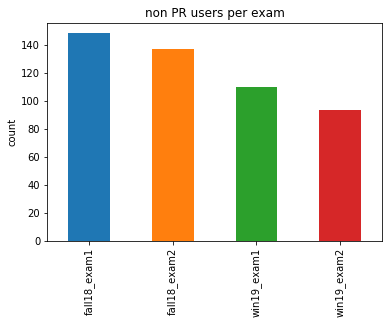

In [70]:
exam_scores[exam_scores['pr_id'].isnull()][['fall18_exam1', 'fall18_exam2', 'win19_exam1', 'win19_exam2']].count().plot.bar()
plt.title('non PR users per exam')
plt.ylabel('count')

Text(0,0.5,'count')

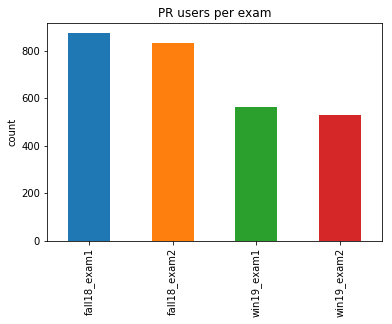

In [71]:
exam_scores[exam_scores['pr_id'].notnull()][['fall18_exam1', 'fall18_exam2', 'win19_exam1', 'win19_exam2']].count().plot.bar()
plt.title('PR users per exam')
plt.ylabel('count')

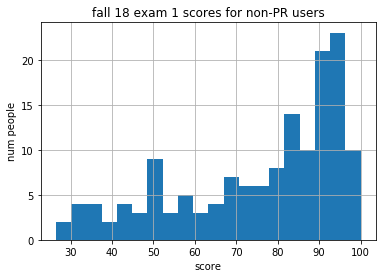

median:  83.0


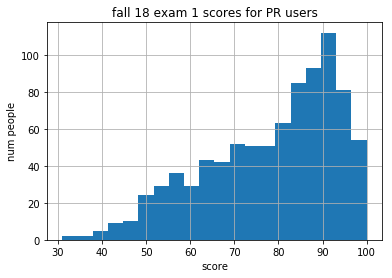

median:  82.0


In [72]:
exam_scores[exam_scores['pr_id'].isnull()]['fall18_exam1'].hist(bins=20)
plt.title('fall 18 exam 1 scores for non-PR users')
plt.xlabel('score')
plt.ylabel('num people')
plt.show()
print('median: ', exam_scores[exam_scores['pr_id'].isnull()]['fall18_exam1'].median())
exam_scores[exam_scores['pr_id'].notnull()]['fall18_exam1'].hist(bins=20)
plt.title('fall 18 exam 1 scores for PR users')
plt.xlabel('score')
plt.ylabel('num people')
plt.show()
print('median: ', exam_scores[exam_scores['pr_id'].notnull()]['fall18_exam1'].median())

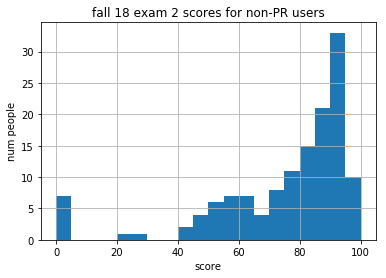

median:  83.5


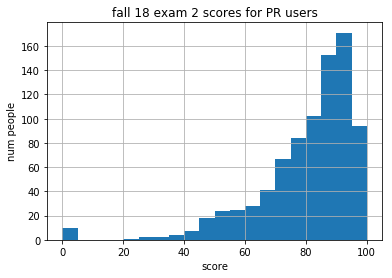

median:  85.0


In [73]:
exam_scores[exam_scores['pr_id'].isnull()]['fall18_exam2'].hist(bins=20)
plt.title('fall 18 exam 2 scores for non-PR users')
plt.xlabel('score')
plt.ylabel('num people')
plt.show()
print('median: ', exam_scores[exam_scores['pr_id'].isnull()]['fall18_exam2'].median())
exam_scores[exam_scores['pr_id'].notnull()]['fall18_exam2'].hist(bins=20)
plt.title('fall 18 exam 2 scores for PR users')
plt.xlabel('score')
plt.ylabel('num people')
plt.show()
print('median: ', exam_scores[exam_scores['pr_id'].notnull()]['fall18_exam2'].median())

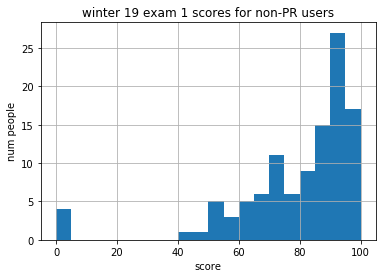

median:  86.5


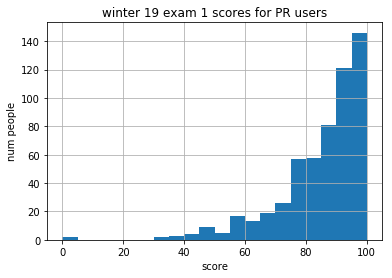

median:  88.5


In [74]:
exam_scores[exam_scores['pr_id'].isnull()]['win19_exam1'].hist(bins=20)
plt.title('winter 19 exam 1 scores for non-PR users')
plt.xlabel('score')
plt.ylabel('num people')
plt.show()
print('median: ', exam_scores[exam_scores['pr_id'].isnull()]['win19_exam1'].median())
exam_scores[exam_scores['pr_id'].notnull()]['win19_exam1'].hist(bins=20)
plt.title('winter 19 exam 1 scores for PR users')
plt.xlabel('score')
plt.ylabel('num people')
plt.show()
print('median: ', exam_scores[exam_scores['pr_id'].notnull()]['win19_exam1'].median())

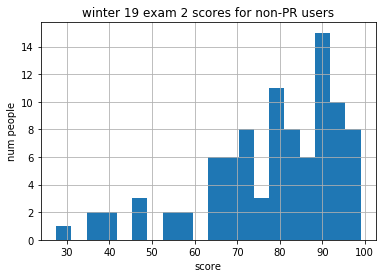

median:  81.5


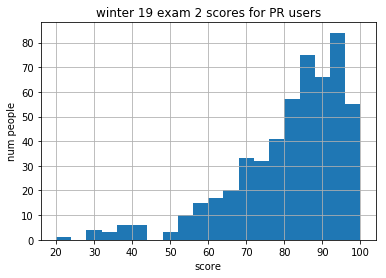

median:  84.5


In [75]:
exam_scores[exam_scores['pr_id'].isnull()]['win19_exam2'].hist(bins=20)
plt.title('winter 19 exam 2 scores for non-PR users')
plt.xlabel('score')
plt.ylabel('num people')
plt.show()
print('median: ', exam_scores[exam_scores['pr_id'].isnull()]['win19_exam2'].median())
exam_scores[exam_scores['pr_id'].notnull()]['win19_exam2'].hist(bins=20)
plt.title('winter 19 exam 2 scores for PR users')
plt.xlabel('score')
plt.ylabel('num people')
plt.show()
print('median: ', exam_scores[exam_scores['pr_id'].notnull()]['win19_exam2'].median())

In [76]:
active_question_list = topics_copy[topics_copy['topic_id'].isin(active_topics['topic_id'].tolist())]['question_id'].tolist()
df_active_q_only = df[df['question_id'].isin(active_question_list)]
df_course_12_active = df_active_q_only[df_active_q_only['course_id'] == 12]
fall_df = df_course_12_active[df_course_12_active['fall_term'] == 1]
winter_df = df_course_12_active[df_course_12_active['winter_term'] == 1]

In [77]:
exam_scores.head()
# check ecoach id in scores_over_volume if errors

,ecoach_id,fall18_exam1,fall18_exam2,win19_exam1,win19_exam2,pr_id
4,8536,NaN,NaN,77.0,72.0,7371.0
7,25112,51.5,64.0,NaN,NaN,9138.0
11,25636,56.5,0.0,NaN,NaN,8842.0
14,23716,NaN,NaN,44.5,31.0,12687.0
45,26974,76.5,72.0,NaN,NaN,7338.0


In [78]:
active_course_12_topics = topics_copy[topics_copy['question_id'].isin(df_course_12_active.question_id.unique())].topic_id.unique()
active_course_12_topics = active_topics[active_topics['topic_id'].isin(active_course_12_topics)]

In [79]:
active_course_12_topics = pd.merge(active_course_12_topics, topics_copy, how='left', on='topic_id').drop(columns=['id'])

In [80]:
exam_1_questions_topics = active_course_12_topics[active_course_12_topics['name'].str.contains('Exam 1')]
exam_2_questions_topics = active_course_12_topics[active_course_12_topics['name'].str.contains('Exam 2')]

In [81]:
def scores_over_volumes(term='fall', exam=1):
    query_string = ''
    if term == 'fall':
        term_df = fall_df
        query_string = 'fall18'
    else:
        term_df = winter_df
        query_string = 'win19'
    if exam == 1:
        exam_questions_topics = exam_1_questions_topics
        query_string = query_string + '_exam1'
    else:
        exam_questions_topics = exam_2_questions_topics
        query_string = query_string + '_exam2'
        
    user_vol_count_df = term_df[term_df['question_id'].isin(exam_questions_topics['question_id'].tolist())].groupby('user_id').count()[['id']].rename(columns={'id':'user_volume_count'})
    exam_vol_somena = pd.merge(user_vol_count_df, exam_scores[exam_scores[query_string].notnull()][['ecoach_id', 'pr_id', query_string]], how='left', left_on='user_id', right_on='pr_id')
    exam_vol = exam_vol_somena[(exam_vol_somena['pr_id'].notnull()) & (exam_vol_somena[query_string].notnull())]
    plt.scatter(exam_vol['user_volume_count'], exam_vol[query_string])
    plt.title('user volume vs user grades ' + query_string)
    plt.xlabel('questions answered for ' + query_string + ' topics')
    plt.ylabel('exam 1 grade')
    plt.show()
    print('correlation coeff: ', np.corrcoef((np.array(exam_vol['user_volume_count']), np.array(exam_vol[query_string])))[0][1])
    exam_vol['user_volume_count'].plot.hist()
    plt.title('histogram of ' + query_string + ' topics volume count over users')
    plt.xlabel('number of questions')
    plt.ylabel('number of users')
    plt.show()
    bins = pd.cut(exam_vol['user_volume_count'], [0, 20, 50, 100, 1000])
    print(exam_vol.groupby(bins)[query_string].agg(['mean', 'median', 'count']))
    return exam_vol

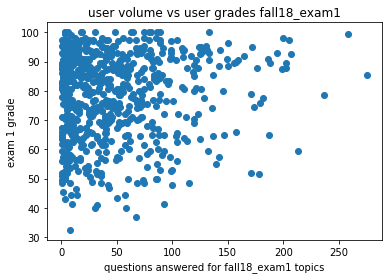

correlation coeff:  0.07176186296280107


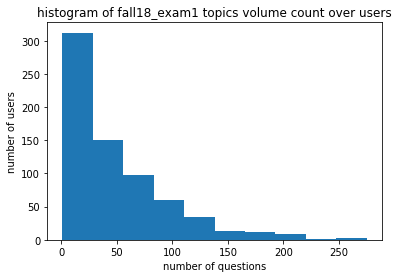

                        mean  median  count
user_volume_count                          
(0, 20]            78.271654   82.75    254
(20, 50]           77.889189   80.50    185
(50, 100]          78.449704   81.50    169
(100, 1000]        81.415663   87.50     83


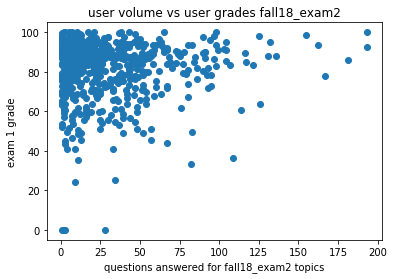

correlation coeff:  0.058976557609833884


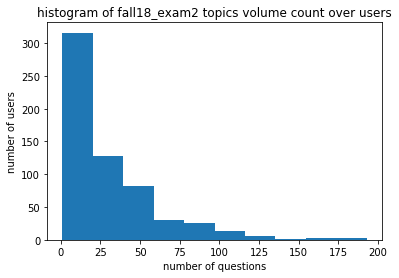

                        mean  median  count
user_volume_count                          
(0, 20]            81.155063    86.0    316
(20, 50]           80.252747    83.5    182
(50, 100]          81.696629    85.0     89
(100, 1000]        84.916667    88.0     21


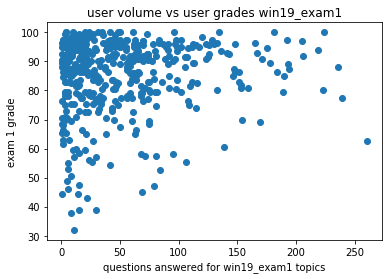

correlation coeff:  0.12130689003357528


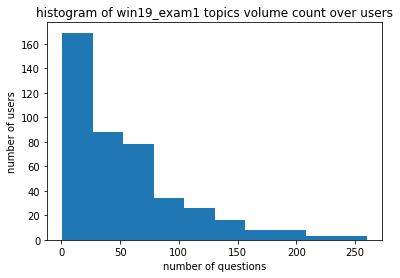

                        mean  median  count
user_volume_count                          
(0, 20]            82.867347   87.50    147
(20, 50]           85.064815   87.25    108
(50, 100]          85.630631   90.00    111
(100, 1000]        87.835821   91.00     67


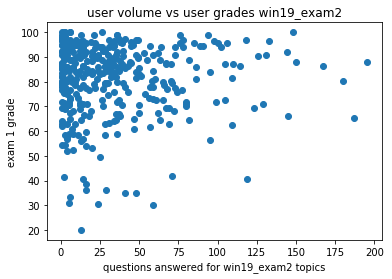

correlation coeff:  0.0166662753186685


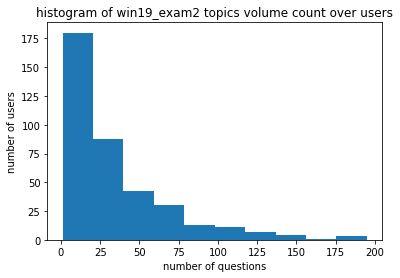

                        mean  median  count
user_volume_count                          
(0, 20]            80.261111    84.0    180
(20, 50]           82.625000    86.0    116
(50, 100]          80.100000    80.5     60
(100, 1000]        82.130435    87.0     23


In [82]:
fall_1 = scores_over_volumes(term='fall', exam=1)
fall_2 = scores_over_volumes(term='fall', exam=2)
win_1 = scores_over_volumes(term='winter', exam=1)
win_2 = scores_over_volumes(term='winter', exam=2)

# Prediction and Factor Analysis on Grades

In [83]:
from sklearn import preprocessing
from sklearn import linear_model
from impyute.imputation.cs import mice
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
import statsmodels.api as sm
from statsmodels.formula.api import ols
from IPython.display import display

In [84]:
def add_competency_scores(fall_1, fall_2, win_1, win_2):
    # adds columns for topic competency for each user if they have one in that topic
    for exam1_topic in exam_1_questions_topics.topic_id.unique():
        if exam1_topic in topics_12:
            if exam1_topic in topic_simulation_dict:
                prediction_df = topic_simulation_dict[exam1_topic]
            else:
                sim_topic = TopicSimulation(exam1_topic, df)
                sim_topic.simulate_all_users()
                prediction_df = sim_topic.get_prediction_df()
                topic_simulation_dict[exam1_topic] = prediction_df
            user_ability_df = prediction_df.sort_values(by='num_questions', ascending=False).groupby('user_id').first()[['current_ability']].rename(columns={'current_ability':'topic ' + str(exam1_topic) + '_comp'})
            fall_1 = pd.merge(fall_1, user_ability_df, how='left', left_on='pr_id', right_on='user_id')
            win_1 = pd.merge(win_1, user_ability_df, how='left', left_on='pr_id', right_on='user_id')
    for exam2_topic in exam_2_questions_topics.topic_id.unique():
        if exam2_topic in topics_12:
            if exam2_topic in topic_simulation_dict:
                prediction_df = topic_simulation_dict[exam2_topic]
            else:
                sim_topic = TopicSimulation(exam2_topic, df)
                sim_topic.simulate_all_users()
                prediction_df = sim_topic.get_prediction_df()
                topic_simulation_dict[exam2_topic] = prediction_df
            user_ability_df = prediction_df.sort_values(by='num_questions', ascending=False).groupby('user_id').first()[['current_ability']].rename(columns={'current_ability':'topic ' + str(exam2_topic) + '_comp'})
            fall_2 = pd.merge(fall_2, user_ability_df, how='left', left_on='pr_id', right_on='user_id')
            win_2 = pd.merge(win_2, user_ability_df, how='left', left_on='pr_id', right_on='user_id')
    return fall_1, fall_2, win_1, win_2

In [85]:
def feature_engineer(fall_1, fall_2, win_1, win_2):
    term_exam = [fall_1, fall_2, win_1, win_2]
    course_name = 'EECS183'
    for i in range(len(term_exam)):
        if i == 0:
            query_string = 'fall18_exam1'
            exam_name = 'Exam 1'
            term_id = 2210
            exam_questions_topics = exam_1_questions_topics
        elif i == 1:
            query_string = 'fall18_exam2'
            exam_name = 'Exam 2'
            term_id = 2210
            exam_questions_topics = exam_2_questions_topics
        elif i == 2:
            query_string = 'win19_exam1'
            exam_name = 'Exam 1'
            term_id = 2220
            exam_questions_topics = exam_1_questions_topics
        else:
            query_string = 'win19_exam2'
            exam_name = 'Exam 2'
            term_id = 2220
            exam_questions_topics = exam_2_questions_topics

        # add num sessions
        term_exam_temp = term_exam[i]
        num_sessions_df = df[df['question_id'].isin(exam_questions_topics.question_id.unique())].groupby(['user_id', 'user_session_id']).size().groupby(['user_id']).count().to_frame().rename(columns={0:'num_sessions'})
        term_exam_temp_2 = pd.merge(term_exam_temp, num_sessions_df, how='left', left_on='pr_id', right_on='user_id')

        # add percent correct
        percent_correct_df = df[df['question_id'].isin(exam_questions_topics.question_id.unique())].groupby('user_id').mean()[['correct']].rename(columns={'correct':'percent_correct'})
        term_exam_temp_3 = pd.merge(term_exam_temp_2, percent_correct_df, how='left', left_on='pr_id', right_on='user_id')

        # add minutes spend
        grouped_session = df[df['question_id'].isin(exam_questions_topics.question_id.unique())].sort_values(by='modified').groupby(['user_id', 'user_session_id'])
        session_length_df = (grouped_session.last()['modified'] - grouped_session.first()['modified']).to_frame().rename(columns={'modified':'session_length'})
        time_used_df = session_length_df.groupby(level=0).sum()
        minutes_used_df = time_used_df['session_length'].dt.total_seconds().div(60).astype(int).to_frame().rename(columns={'session_length':'minutes_used'})
        term_exam_temp_4 = pd.merge(term_exam_temp_3, minutes_used_df, how='left', left_on='pr_id', right_on='user_id')
        
        # add perecent correct over last 20
        pcor_last20_df = df[df['question_id'].isin(exam_questions_topics.question_id.unique())].sort_values(by='modified', ascending=False).groupby('user_id').head(20)[['correct', 'user_id']].groupby('user_id').mean().rename(columns={'correct':'pcor_last20'})
        term_exam_temp_5 = pd.merge(term_exam_temp_4, pcor_last20_df, how='left', left_on='pr_id', right_on='user_id')
        
        # add percent correct if we ignore first 15 if there's more than 30 answers for a user
        grouped = df[df['question_id'].isin(exam_questions_topics.question_id.unique())].sort_values(by='modified').groupby('user_id')
        grouped = grouped.filter(lambda x: x['id'].count() > 30)
        forget_first15_df = grouped[['correct', 'user_id']].groupby('user_id').apply(lambda group: group.iloc[15:,:]).rename(columns={'user_id':'pr_id'}).groupby('user_id').mean().drop(columns=['pr_id']).rename(columns={'correct':'pcor_forget_first15'})
        term_exam_temp_6 = pd.merge(term_exam_temp_5, forget_first15_df, how='left', left_on='pr_id', right_on='user_id')
        term_exam_temp_6.pcor_forget_first15.fillna(term_exam_temp_6.percent_correct, inplace=True)
        
        # add crammer or not crammer based on if users time to exam answers third quartile is < 1.5 days
        exam_dates_183 = exam_dates[exam_dates['default_source'] == 'EECS183'][['exam_date', 'term_id', 'name']]
        exam_num_date = exam_dates_183[(exam_dates_183['term_id'] == term_id) & (exam_dates_183['name'] == exam_name)]['exam_date'].values[0]
        exam_num_answers = df[df['question_id'].isin(exam_questions_topics.question_id.unique())]
        exam_num_answers = exam_num_answers[exam_num_answers['modified'] < exam_num_date]
        exam_num_answers['days_to_exam'] = (exam_num_date - exam_num_answers['modified']).dt.total_seconds() / (60 * 60 * 24)
        third_quart_cram = exam_num_answers.groupby('user_id')[['days_to_exam']].quantile([0.75])
        term_exam_temp_7 = pd.merge(term_exam_temp_6, third_quart_cram, how='left', left_on='pr_id', right_on='user_id')
        term_exam_temp_7['crammer'] = 1
        term_exam_temp_7.loc[term_exam_temp_7['days_to_exam'] > 1.5, 'crammer'] = 0
        term_exam_temp_7 = term_exam_temp_7.drop(columns=['days_to_exam'])
        
        # merge gpao
        gpao_term_exam = gpao[(gpao['default_source'] == course_name) & (gpao['TERM_CD'] == term_id)][['EXCL_CLASS_CUM_GPA', 'ecoach_id', 'pr_id']]
        term_exam_temp_8 = pd.merge(term_exam_temp_7, gpao_term_exam, how='left', on=['ecoach_id', 'pr_id']).rename(columns={'EXCL_CLASS_CUM_GPA':'gpao'})
        term_exam_temp_8 = term_exam_temp_8[term_exam_temp_8['gpao'].notna()]
        
        # uncomment to add question volume per topic
        '''
        grouped = exam_questions_topics.groupby('topic_id')
        for name, group in grouped:
            vol_all_users_topic_df = df[df['question_id'].isin(group['question_id'].tolist())][['question_id', 'user_id']].groupby('user_id').count().rename(columns={'question_id':'topic ' + str(name) + '_vol'})
            term_exam_temp_4 = pd.merge(term_exam_temp_4, vol_all_users_topic_df, how='left', left_on='pr_id', right_on='user_id')
        term_exam_temp_4 = term_exam_temp_4.fillna(0)
        '''

        term_exam[i] = term_exam_temp_8
        
    return term_exam[0], term_exam[1], term_exam[2], term_exam[3]

In [86]:
def factor_importance_and_prediction(fall_1, fall_2, win_1, win_2, imp_fact=False, threshold=False):
    term_exam = [fall_1, fall_2, win_1, win_2]
    term_exam_str = ['fall_1', 'fall_2', 'win_1', 'win_2']
    
    for i in range(len(term_exam)):
        if i == 0:
            query_string = 'fall18_exam1'
        elif i == 1:
            query_string = 'fall18_exam2'
        elif i == 2:
            query_string = 'win19_exam1'
        else:
            query_string = 'win19_exam2'
        
        # only uses users that have at least 2 competency scores
        if threshold:
            term_exam[i] = term_exam[i].dropna(thresh=(len(term_exam[i].columns) - len([s for s in term_exam[i].columns if 'comp' in s]) + 2))
        # drop topic with almost all na values
        if 'topic 363_comp' in term_exam[i].columns:
            term_exam[i] = term_exam[i].drop(columns='topic 363_comp')
        
        topic_comp_list = [s for s in term_exam[i].columns if 'comp' in s]
        min_max_scaler = MinMaxScaler()
        y = term_exam[i][query_string].values.reshape(-1,1)
        x = term_exam[i][['pcor_forget_first15', 'user_volume_count', 'crammer', 'gpao']].values
        x = min_max_scaler.fit_transform(x)
        poly = PolynomialFeatures(interaction_only=True, include_bias=False)
        x = poly.fit_transform(x)
        
        linear = LinearRegression()
        rfecv = RFECV(estimator=linear, step=1, cv=4, scoring='neg_mean_squared_error')
        rfecv.fit(x,y)
        print('optimal number of featuers: %d' % rfecv.n_features_)
        
        plt.figure()
        plt.xlabel('number of features selected')
        plt.ylabel('cv score')
        plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
        plt.show()

        ridge = Ridge()
        parameters = {'alpha':[1e-5, 1e-3, 0.01, 1, 5, 10, 100]}
        ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=4)
        ridge_regressor.fit(x, y)
        
        base_score = ridge_regressor.best_score_
        print(term_exam_str[i] + 'ridge MSE: ', ridge_regressor.best_score_)  
        
        # uncomment to get MSE based on competency metrics
        '''
        ridge = Ridge()
        x2 = term_exam[i][topic_comp_list].values
        x2 = mice(x2)
        x2 = min_max_scaler.fit_transform(x2)
        featureSelection = SelectFromModel(ridge)
        featureSelection.fit(x2,y)
        x2 = featureSelection.transform(x2)
        ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=4)
        ridge_regressor.fit(x2,y)
        print(term_exam_str[i] + 'feature selected comp MSE: ', ridge_regressor.best_score_)
        '''
        
        if imp_fact:
            for j in range(4):
                col_names = ['user_volume_count', 'num_sessions', 'percent_correct', 'minutes_used']
                col_name = col_names.pop(j)
                
                x = term_exam[i][col_names].values

                ridge = Ridge()
                ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=4)
                ridge_regressor.fit(x, y)

                print('drop ', col_name, round(((ridge_regressor.best_score_ - base_score) / base_score) * 100, 2), '% change MSE')

In [87]:
# append volume, competency, percent correct, time spent, number of sessions
fall_1, fall_2, win_1, win_2 = add_competency_scores(fall_1, fall_2, win_1, win_2)
fall_1, fall_2, win_1, win_2 = feature_engineer(fall_1, fall_2, win_1, win_2)

/Users/sethsaps/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


optimal number of featuers: 4


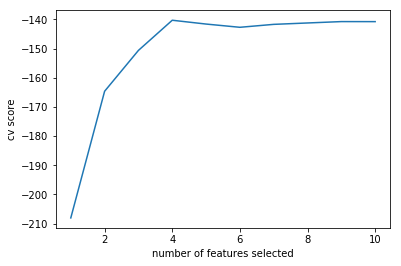

fall_1ridge MSE:  -140.07550241116923
optimal number of featuers: 10


/Users/sethsaps/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


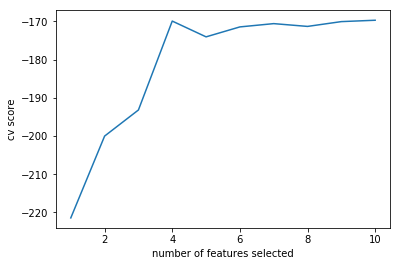

fall_2ridge MSE:  -169.44197975610405
optimal number of featuers: 5


/Users/sethsaps/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


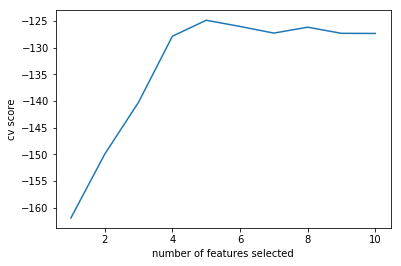

win_1ridge MSE:  -126.10869467352691
optimal number of featuers: 8


/Users/sethsaps/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


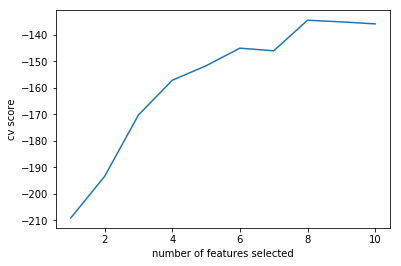

win_2ridge MSE:  -135.75780110312286


In [88]:
factor_importance_and_prediction(fall_1, fall_2, win_1, win_2)

In [89]:
gpao_pred = [-181.64, -187.92, -154.73, -181.87]
pcor_pred = [-174.97, -211.38, -132.56, -191.1]
all_plus_interact = [-140.07, -169.44, -126.11, -135.76]
all_minus_gpao_interact = [-151.04, -188.06, -127.85, -164.47]

mse_pred_df = pd.DataFrame(data={'pcorrect_pred':pcor_pred,
                   'gpao_pred':gpao_pred,
                   'all_with_interaction':all_plus_interact,
                   'all_minus_gpao_with_interaction':all_minus_gpao_interact})
mse_pred_df.index = ('fall_1', 'fall_2', 'win_1', 'win_2')
mse_pred_df.head()

,pcorrect_pred,gpao_pred,all_with_interaction,all_minus_gpao_with_interaction
fall_1,-174.97,-181.64,-140.07,-151.04
fall_2,-211.38,-187.92,-169.44,-188.06
win_1,-132.56,-154.73,-126.11,-127.85
win_2,-191.10,-181.87,-135.76,-164.47


optimal number of featuers: 2


/Users/sethsaps/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


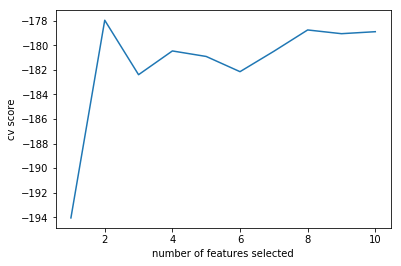

fall_1ridge MSE:  -177.35106987727045
optimal number of featuers: 3


/Users/sethsaps/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


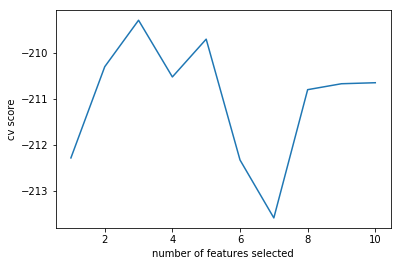

fall_2ridge MSE:  -206.73875187815065
optimal number of featuers: 2


/Users/sethsaps/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


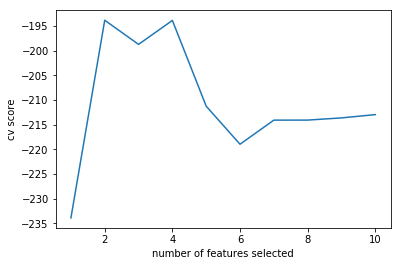

win_1ridge MSE:  -211.24009396922105
optimal number of featuers: 9


/Users/sethsaps/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


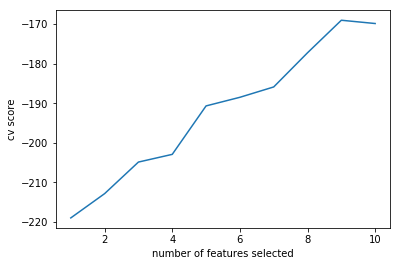

win_2ridge MSE:  -169.7656634948144
optimal number of featuers: 2


/Users/sethsaps/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


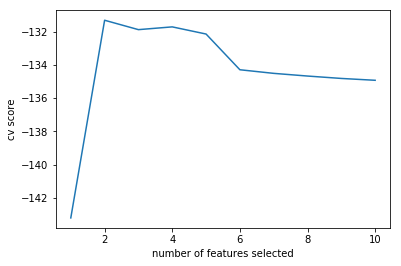

fall_1ridge MSE:  -134.3882962053265
optimal number of featuers: 4


/Users/sethsaps/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


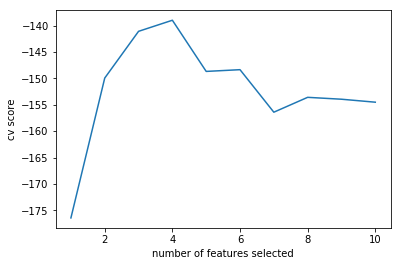

fall_2ridge MSE:  -144.58903365971852
optimal number of featuers: 3


/Users/sethsaps/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


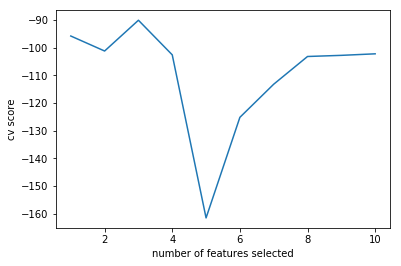

win_1ridge MSE:  -85.95699931227925
optimal number of featuers: 6


/Users/sethsaps/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


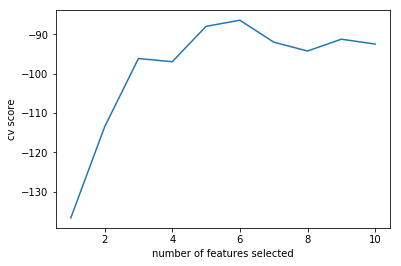

win_2ridge MSE:  -92.17655999639011
optimal number of featuers: 5


/Users/sethsaps/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


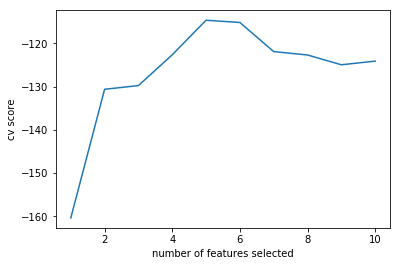

fall_1ridge MSE:  -115.34463484764305
optimal number of featuers: 3


/Users/sethsaps/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


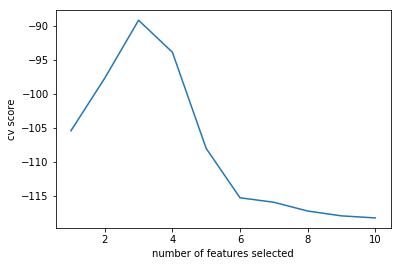

fall_2ridge MSE:  -98.38547281753294
optimal number of featuers: 3


/Users/sethsaps/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


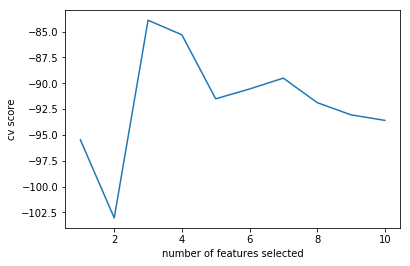

win_1ridge MSE:  -85.10748479426665
optimal number of featuers: 1


/Users/sethsaps/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


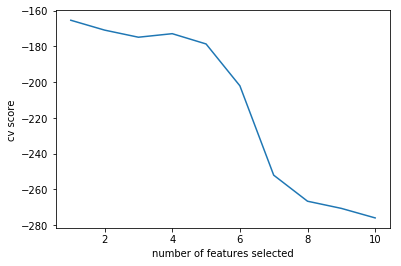

win_2ridge MSE:  -142.7740055416455
optimal number of featuers: 3


/Users/sethsaps/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


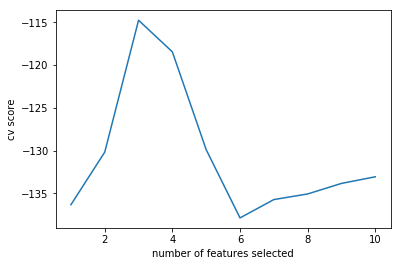

fall_1ridge MSE:  -106.89424658203839
optimal number of featuers: 2


/Users/sethsaps/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


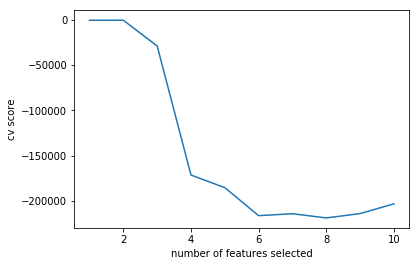

fall_2ridge MSE:  -187.8133026429462


/Users/sethsaps/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


optimal number of featuers: 5


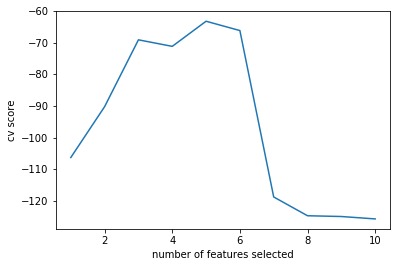

win_1ridge MSE:  -77.81262021644663
optimal number of featuers: 3


/Users/sethsaps/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


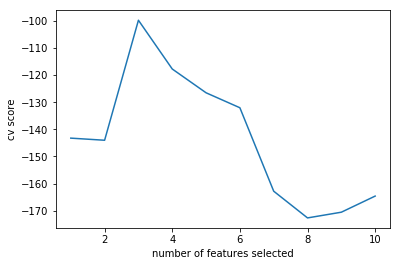

win_2ridge MSE:  -112.54569259663532


,0to20,20to50,50to100,100plus
fall_1,-202.85,-134.54,-108.43,-104.19
fall_2,-195.60,-147.01,-109.10,-168.00
win_1,-206.94,-83.77,-80.47,-67.97
win_2,-239.27,-150.81,-128.58,-66.07


In [90]:
# bin each term_exam df by volume then look at MSE from pcor
zero_twenty_dfs = []
twenty_fifty_dfs = []
fifty_hundred_dfs = []
hundred_plus_dfs = []
binned_dfs = [zero_twenty_dfs, twenty_fifty_dfs, fifty_hundred_dfs, hundred_plus_dfs]
for term_exam in [fall_1, fall_2, win_1, win_2]:
    bins = pd.cut(term_exam['user_volume_count'], [0, 20, 50, 100, 1000])
    grouped = term_exam.groupby(bins)
    i = 0
    for name, group in grouped:
        binned_dfs[i].append(group)
        i += 1
for binned_df in binned_dfs:
    factor_importance_and_prediction(binned_df[0], binned_df[1], binned_df[2], binned_df[3])

pcor_over_vol_df = pd.DataFrame(data={'0to20':[-202.85, -195.60, -206.94, -239.27],
                   '20to50':[-134.54, -147.01, -83.77, -150.81],
                   '50to100':[-108.43, -109.10, -80.47, -128.58],
                   '100plus':[-104.19, -168.00, -67.97, -66.07]})
pcor_over_vol_df.index = ['fall_1', 'fall_2', 'win_1', 'win_2']
pcor_over_vol_df

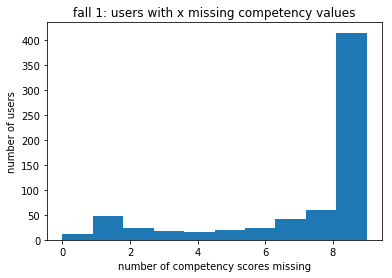

In [91]:
fall_1.isna().sum(axis=1).plot.hist()
plt.title('fall 1: users with x missing competency values')
plt.xlabel('number of competency scores missing')
plt.ylabel('number of users')
plt.show()

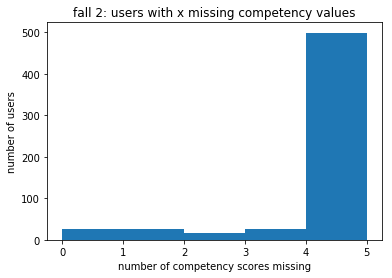

In [92]:
fall_2.isna().sum(axis=1).plot.hist(bins=5)
plt.title('fall 2: users with x missing competency values')
plt.xlabel('number of competency scores missing')
plt.ylabel('number of users')
plt.show()

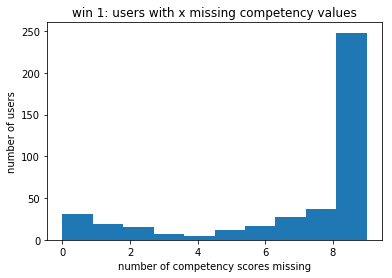

In [93]:
win_1.isna().sum(axis=1).plot.hist()
plt.title('win 1: users with x missing competency values')
plt.xlabel('number of competency scores missing')
plt.ylabel('number of users')
plt.show()

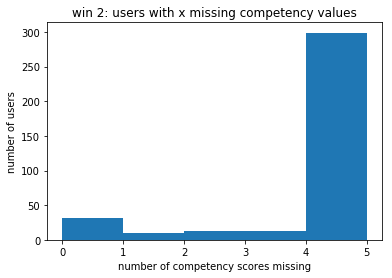

In [94]:
win_2.isna().sum(axis=1).plot.hist(bins=5)
plt.title('win 2: users with x missing competency values')
plt.xlabel('number of competency scores missing')
plt.ylabel('number of users')
plt.show()

In [95]:
dropped_df = pd.DataFrame(data={
    'users_before':[len(fall_1), len(fall_2), len(win_1), len(win_2)],
    'users_after':[len(fall_1.dropna(thresh=(len(fall_1.columns) - len([s for s in fall_1.columns if 'comp' in s]) + 2))),
                     len(fall_2.dropna(thresh=(len(fall_2.columns) - len([s for s in fall_2.columns if 'comp' in s]) + 2))),
                     len(win_1.dropna(thresh=(len(win_1.columns) - len([s for s in win_1.columns if 'comp' in s]) + 2))),
                     len(win_2.dropna(thresh=(len(win_2.columns) - len([s for s in win_2.columns if 'comp' in s]) + 2)))]
})
dropped_df.index = ('fall 1', 'fall 2', 'win 1', 'win 2')
dropped_df.head()

,users_before,users_after
fall 1,674,199
fall 2,593,94
win 1,417,132
win 2,366,67


topic 336_comp
0.6258130535346819


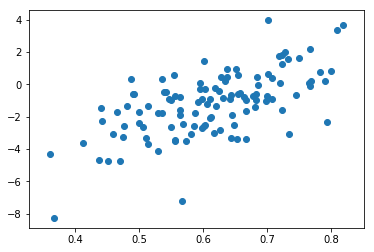

topic 338_comp
0.7141047258502035


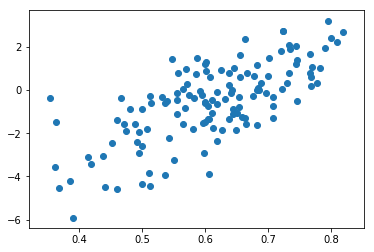

topic 339_comp
0.744362862857658


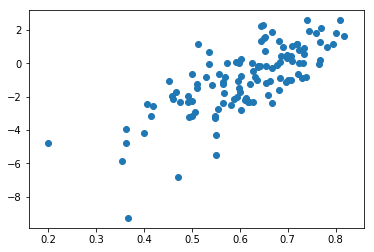

topic 342_comp
0.6634316986761988


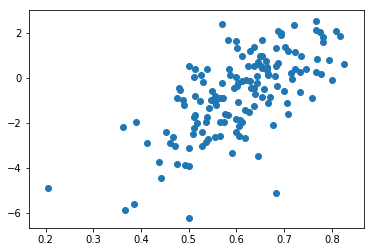

topic 346_comp
0.7366486720029708


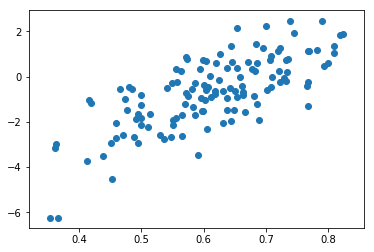

topic 354_comp
0.7492481604773841


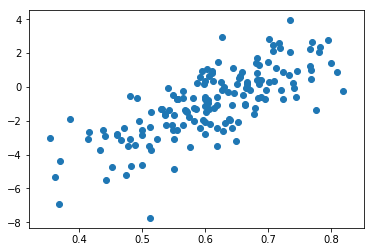

topic 356_comp
0.6618577416508716


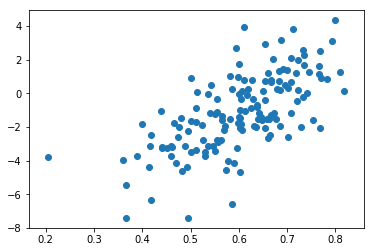

topic 362_comp
0.7142765720328226


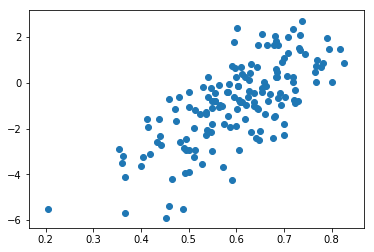

topic 363_comp
0.8574652267261507


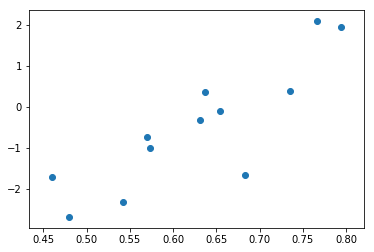

In [96]:
topic_comp_list = [s for s in fall_1.columns if 'comp' in s]
for topic in topic_comp_list:
    print(topic)
    temp = fall_1[['percent_correct', topic]].dropna()
    print(np.corrcoef(np.array(temp['percent_correct']), np.array(temp[topic]))[0][1])
    plt.scatter(np.array(temp['percent_correct']), np.array(temp[topic]))
    plt.show()

## Prediction and Factor Analysis with GPAO

In [97]:
mse_pred_df.index = ('fall18_exam1', 'fall18_exam2', 'win19_exam1', 'win19_exam2')
mse_pred_df.head()

,pcorrect_pred,gpao_pred,all_with_interaction,all_minus_gpao_with_interaction
fall18_exam1,-174.97,-181.64,-140.07,-151.04
fall18_exam2,-211.38,-187.92,-169.44,-188.06
win19_exam1,-132.56,-154.73,-126.11,-127.85
win19_exam2,-191.10,-181.87,-135.76,-164.47


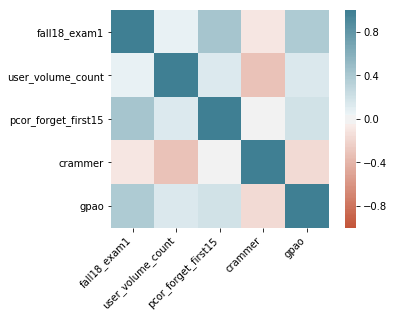

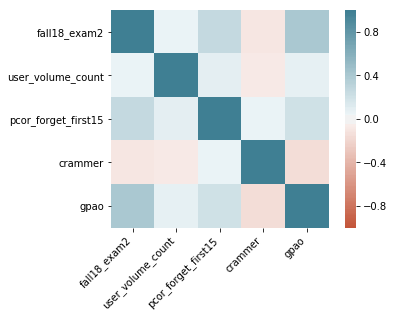

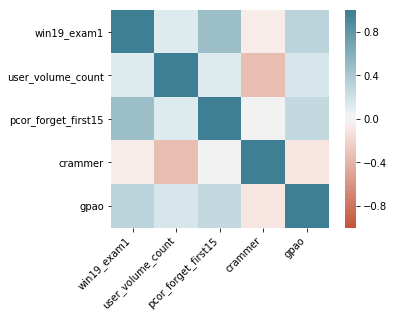

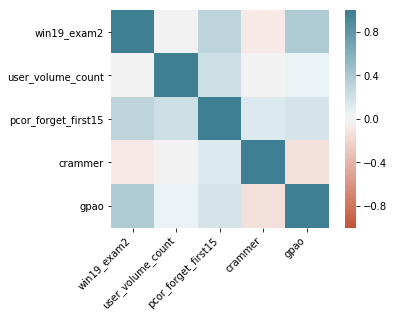

In [98]:
term_exam = [fall_1, fall_2, win_1, win_2]
for i in range(len(term_exam)):
    if i == 0:
        query_string = 'fall18_exam1'
    elif i == 1:
        query_string = 'fall18_exam2'
    elif i == 2:
        query_string = 'win19_exam1'
    else:
        query_string = 'win19_exam2'
        
    corr = term_exam[i][[query_string, 'user_volume_count', 'pcor_forget_first15', 'crammer', 'gpao']].corr()
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    plt.show()

In [99]:
def get_term_exam_nonPR(exam_scores):
    fall_1_nonPR = exam_scores[(exam_scores['pr_id'].isnull()) & (exam_scores['fall18_exam1'].notnull())][['ecoach_id', 'fall18_exam1']]
    fall_2_nonPR = exam_scores[(exam_scores['pr_id'].isnull()) & (exam_scores['fall18_exam2'].notnull())][['ecoach_id', 'fall18_exam2']]
    win_1_nonPR = exam_scores[(exam_scores['pr_id'].isnull()) & (exam_scores['win19_exam1'].notnull())][['ecoach_id', 'win19_exam1']]
    win_2_nonPR = exam_scores[(exam_scores['pr_id'].isnull()) & (exam_scores['win19_exam2'].notnull())][['ecoach_id', 'win19_exam2']]
    term_exam = [fall_1_nonPR, fall_2_nonPR, win_1_nonPR, win_2_nonPR]
    course_name = 'EECS183'
    for i in range(len(term_exam)):
        if i == 0:
            query_string = 'fall18_exam1'
            exam_name = 'Exam 1'
            term_id = 2210
            exam_questions_topics = exam_1_questions_topics
        elif i == 1:
            query_string = 'fall18_exam2'
            exam_name = 'Exam 2'
            term_id = 2210
            exam_questions_topics = exam_2_questions_topics
        elif i == 2:
            query_string = 'win19_exam1'
            exam_name = 'Exam 1'
            term_id = 2220
            exam_questions_topics = exam_1_questions_topics
        else:
            query_string = 'win19_exam2'
            exam_name = 'Exam 2'
            term_id = 2220
            exam_questions_topics = exam_2_questions_topics

        # merge gpao
        gpao_term_exam = gpao[(gpao['default_source'] == course_name) & (gpao['TERM_CD'] == term_id)][['EXCL_CLASS_CUM_GPA', 'ecoach_id']]
        term_exam_temp_1 = pd.merge(term_exam[i], gpao_term_exam, how='left', on=['ecoach_id']).rename(columns={'EXCL_CLASS_CUM_GPA':'gpao'})
        term_exam_temp_1 = term_exam_temp_1[term_exam_temp_1['gpao'].notna()]
        
        # add empty cols in order to append later
        term_exam_temp_1['user_volume_count'] = np.nan
        term_exam_temp_1['pcor_forget_first15'] = np.nan
        term_exam_temp_1['crammer'] = np.nan
        term_exam_temp_1['pr_id'] = np.nan
        
        term_exam[i] = term_exam_temp_1
        
    return term_exam[0], term_exam[1], term_exam[2], term_exam[3]

In [100]:
def evaluate_pr_vs_nonPR(redefine_pr_user=False):
    term_exam = [fall_1, fall_2, win_1, win_2]
    term_exam_nonPR = [fall_1_nonPR, fall_2_nonPR, win_1_nonPR, win_2_nonPR]
    term_exam_all_coefs = []
    for i in range(4):
        if i == 0:
            exam_name = 'fall18_exam1'
        elif i == 1:
            exam_name = 'fall18_exam2'
        elif i == 2:
            exam_name = 'win19_exam1'
        else:
            exam_name = 'win19_exam2'
    
        term_exam_all = term_exam[i][['ecoach_id', exam_name, 'gpao', 'user_volume_count', 'pcor_forget_first15', 'crammer', 'pr_id']].append(term_exam_nonPR[i])
        term_exam_all['pr_user'] = 0
        term_exam_all.loc[term_exam_all['pr_id'].notnull(), 'pr_user'] = 1
        term_exam_all.head()
        term_exam_all = term_exam_all.drop(columns=['pr_id', 'ecoach_id']).fillna(0)
    
        # custom define what a pr_user is based on other parameters
        if redefine_pr_user:
            term_exam_all.loc[term_exam_all['user_volume_count']<50, 'pr_user'] = 0
            
        linear = LinearRegression()
        min_max_scaler = MinMaxScaler()
        x = term_exam_all[['gpao', 'pr_user']].values
        y = term_exam_all[[exam_name]].values.reshape(-1, 1)
        linear.fit(x, y)
        term_exam_all_coefs.append(pd.DataFrame({"Feature":['gpao', 'pr_user'],"Coefficients":np.transpose(linear.coef_[0,])}))

        mod = ols(exam_name + ' ~ gpao + pr_user', data=term_exam_all).fit()
        aov_table = sm.stats.anova_lm(mod, typ=2)
        print('type 2 anova for ' + exam_name)
        print(aov_table)
    
    return term_exam_all_coefs

In [101]:
fall_1_nonPR, fall_2_nonPR, win_1_nonPR, win_2_nonPR = get_term_exam_nonPR(exam_scores)

In [102]:
term_exam_all_coefs = evaluate_pr_vs_nonPR()
for term_exam_coef in term_exam_all_coefs:
    display(term_exam_coef)

type 2 anova for fall18_exam1
                 sum_sq     df           F        PR(>F)
gpao       32351.093185    1.0  156.002819  7.048615e-33
pr_user      120.705679    1.0    0.582065  4.457252e-01
Residual  168803.294305  814.0         NaN           NaN
type 2 anova for fall18_exam2
                 sum_sq     df           F        PR(>F)
gpao       32993.632940    1.0  143.622113  2.626801e-30
pr_user     1410.024753    1.0    6.137873  1.345972e-02
Residual  165631.940776  721.0         NaN           NaN
type 2 anova for win19_exam1
                sum_sq     df          F        PR(>F)
gpao       7592.497085    1.0  40.377648  4.631115e-10
pr_user     233.702835    1.0   1.242855  2.654446e-01
Residual  96275.009889  512.0        NaN           NaN
type 2 anova for win19_exam2
                sum_sq     df          F        PR(>F)
gpao      11580.485413    1.0  61.721433  2.985848e-14
pr_user      40.231360    1.0   0.214424  6.435474e-01
Residual  83680.761476  446.0        NaN 

,Feature,Coefficients
0,gpao,11.304397
1,pr_user,1.021232


,Feature,Coefficients
0,gpao,12.526556
1,pr_user,3.653457


,Feature,Coefficients
0,gpao,6.810735
1,pr_user,1.770635


,Feature,Coefficients
0,gpao,9.883032
1,pr_user,-0.787448


In [103]:
term_exam_all_coefs = evaluate_pr_vs_nonPR(redefine_pr_user=True)
for term_exam_coef in term_exam_all_coefs:
    display(term_exam_coef)

type 2 anova for fall18_exam1
                 sum_sq     df           F        PR(>F)
gpao       32853.728474    1.0  158.316256  2.657064e-33
pr_user        3.033727    1.0    0.014619  9.037929e-01
Residual  168920.966257  814.0         NaN           NaN
type 2 anova for fall18_exam2
                 sum_sq     df           F        PR(>F)
gpao       34809.289512    1.0  150.607875  1.416182e-31
pr_user      400.627813    1.0    1.733379  1.883982e-01
Residual  166641.337717  721.0         NaN           NaN
type 2 anova for win19_exam1
                sum_sq     df          F        PR(>F)
gpao       7719.467473    1.0  41.215969  3.112745e-10
pr_user     614.633645    1.0   3.281667  7.064355e-02
Residual  95894.079079  512.0        NaN           NaN
type 2 anova for win19_exam2
                sum_sq     df          F        PR(>F)
gpao      11915.785851    1.0  63.581519  1.304495e-14
pr_user     136.319531    1.0   0.727388  3.941888e-01
Residual  83584.673305  446.0        NaN 

,Feature,Coefficients
0,gpao,11.416031
1,pr_user,-0.133488


,Feature,Coefficients
0,gpao,12.781873
1,pr_user,2.082589


,Feature,Coefficients
0,gpao,6.764526
1,pr_user,2.325496


,Feature,Coefficients
0,gpao,9.847567
1,pr_user,-1.417272
